# 에너지 사용량 예측 대회 🏢⚡

## 프로젝트 개요
- **목표**: 건물의 에너지 사용량을 정확하게 예측
- **데이터**: 건물 정보, 날씨 데이터, 과거 에너지 사용량 등
- **평가**: RMSE (Root Mean Square Error) 기준
- **접근법**: 회귀 문제로 접근, 앙상블 기법 활용

## 주요 전략
1. **데이터 탐색**: 각 변수의 분포와 상관관계 분석
2. **특성 엔지니어링**: 시간 특성, 상호작용 변수 생성
3. **이상치 처리**: 에너지 사용량의 극값 처리
4. **모델 앙상블**: 여러 알고리즘의 장점 결합
5. **하이퍼파라미터 최적화**: 베이지안 최적화 또는 그리드 서치

In [33]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 머신러닝 라이브러리
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

# 통계 분석
from scipy import stats

# XGBoost와 LightGBM (고성능 부스팅 모델)
try:
    from xgboost import XGBRegressor
    print("✅ XGBoost 로드 성공")
except ImportError:
    print("❌ XGBoost 설치 필요: pip install xgboost")

try:
    from lightgbm import LGBMRegressor
    print("✅ LightGBM 로드 성공")
except ImportError:
    print("❌ LightGBM 설치 필요: pip install lightgbm")

# 베이지안 최적화 (하이퍼파라미터 튜닝)
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer
    print("✅ Scikit-optimize 로드 성공")
except ImportError:
    print("❌ Scikit-optimize 설치 필요: pip install scikit-optimize")

# 시각화 설정
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("🎯 에너지 사용량 예측 모델 개발 시작!")

✅ XGBoost 로드 성공
❌ LightGBM 설치 필요: pip install lightgbm
❌ Scikit-optimize 설치 필요: pip install scikit-optimize
🎯 에너지 사용량 예측 모델 개발 시작!


In [34]:
# 데이터 로딩
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv') 
building_info = pd.read_csv('building_info.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("=== 데이터 기본 정보 ===")
print(f"📊 훈련 데이터 크기: {train.shape}")
print(f"📊 테스트 데이터 크기: {test.shape}")
print(f"🏢 건물 정보 크기: {building_info.shape}")
print(f"📝 제출 형식 크기: {sample_submission.shape}")

print("\n=== 훈련 데이터 상세 정보 ===")
print(train.info())

print("\n=== 테스트 데이터 상세 정보 ===")  
print(test.info())

print("\n=== 건물 정보 데이터 ===")
print(building_info.info())

=== 데이터 기본 정보 ===
📊 훈련 데이터 크기: (204000, 10)
📊 테스트 데이터 크기: (16800, 7)
🏢 건물 정보 크기: (100, 7)
📝 제출 형식 크기: (16800, 2)

=== 훈련 데이터 상세 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_date_time  204000 non-null  object 
 1   건물번호           204000 non-null  int64  
 2   일시             204000 non-null  object 
 3   기온(°C)         204000 non-null  float64
 4   강수량(mm)        204000 non-null  float64
 5   풍속(m/s)        204000 non-null  float64
 6   습도(%)          204000 non-null  float64
 7   일조(hr)         204000 non-null  float64
 8   일사(MJ/m2)      204000 non-null  float64
 9   전력소비량(kWh)     204000 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 15.6+ MB
None

=== 테스트 데이터 상세 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16800 entries, 0 to 16799
Data columns (total 7 columns):
 #   Column    

In [35]:
# 데이터 샘플 확인
print("=== 훈련 데이터 샘플 ===")
display(train.head())

print("\n=== 건물 정보 샘플 ===")
display(building_info.head())

print("\n=== 제출 형식 확인 ===")
display(sample_submission.head())

# 기본 통계 정보
print("\n=== 타겟 변수 통계 (에너지 사용량) ===")
if 'target' in train.columns:
    target_col = 'target'
elif 'energy_consumption' in train.columns:
    target_col = 'energy_consumption'
else:
    # 타겟 변수 찾기
    target_col = [col for col in train.columns if col not in test.columns and col != 'id'][0]
    
print(f"타겟 변수: {target_col}")
print(train[target_col].describe())

# 결측치 확인
print("\n=== 결측치 현황 ===")
print("훈련 데이터:")
print(train.isnull().sum())
print("\n테스트 데이터:")
print(test.isnull().sum())
print("\n건물 정보:")
print(building_info.isnull().sum())

=== 훈련 데이터 샘플 ===


,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20240601 00,1,20240601 00,18.3,0.0,2.6,82.0,0.0,0.0,5794.80
1,1_20240601 01,1,20240601 01,18.3,0.0,2.7,82.0,0.0,0.0,5591.85
2,1_20240601 02,1,20240601 02,18.1,0.0,2.6,80.0,0.0,0.0,5338.17
3,1_20240601 03,1,20240601 03,18.0,0.0,2.6,81.0,0.0,0.0,4554.42
4,1_20240601 04,1,20240601 04,17.8,0.0,1.3,81.0,0.0,0.0,3602.25



=== 건물 정보 샘플 ===


,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,호텔,82912.71,77586.00,-,-,-
1,2,상용,40658.90,30392.82,-,-,-
2,3,병원,560431.00,418992.00,278.58,-,-
3,4,호텔,41813.29,23715.71,-,-,-
4,5,학교,403749.39,248507.00,1983.05,1025,250



=== 제출 형식 확인 ===


,num_date_time,answer
0,1_20240825 00,0
1,1_20240825 01,0
2,1_20240825 02,0
3,1_20240825 03,0
4,1_20240825 04,0



=== 타겟 변수 통계 (에너지 사용량) ===
타겟 변수: 일조(hr)
count    204000.000000
mean          0.277459
std           0.396476
min           0.000000
25%           0.000000
50%           0.000000
75%           0.600000
max           1.000000
Name: 일조(hr), dtype: float64

=== 결측치 현황 ===
훈련 데이터:
num_date_time    0
건물번호             0
일시               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
일조(hr)           0
일사(MJ/m2)        0
전력소비량(kWh)       0
dtype: int64

테스트 데이터:
num_date_time    0
건물번호             0
일시               0
기온(°C)           0
강수량(mm)          0
풍속(m/s)          0
습도(%)            0
dtype: int64

건물 정보:
건물번호            0
건물유형            0
연면적(m2)         0
냉방면적(m2)        0
태양광용량(kW)       0
ESS저장용량(kWh)    0
PCS용량(kW)       0
dtype: int64


🎯 타겟 변수로 선택: 일조(hr)


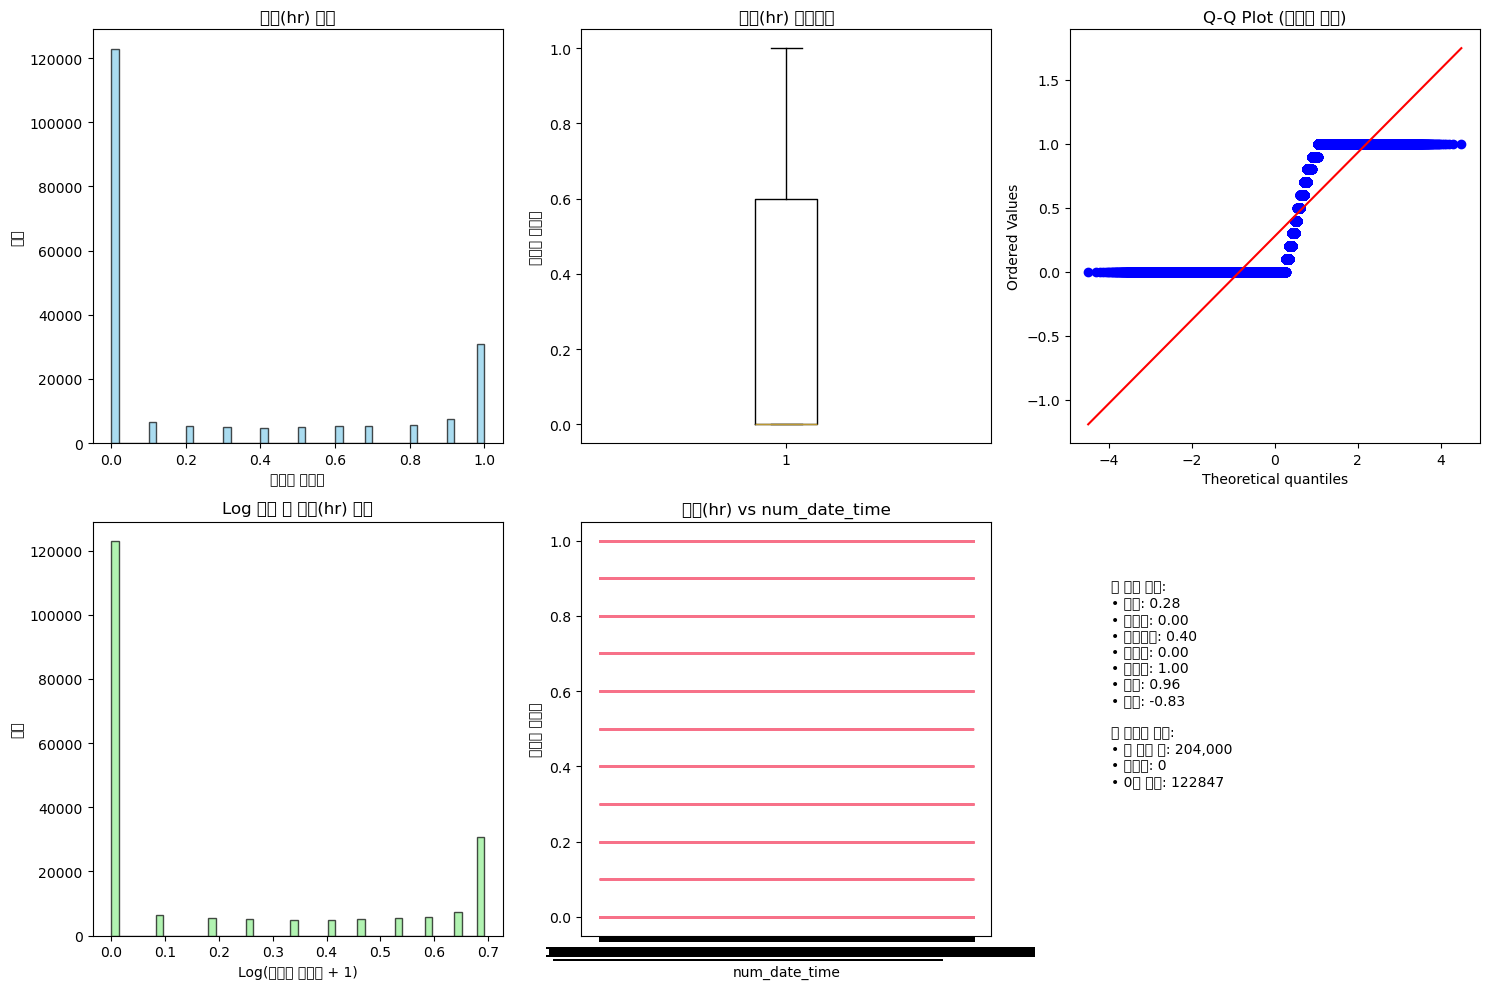


📈 이상치 분석:
• 하한선: -0.90
• 상한선: 1.50
• 이상치 개수: 0 (0.0%)


In [36]:
# 타겟 변수 분포 시각화
plt.figure(figsize=(15, 10))

# 타겟 변수가 확실하지 않으므로 동적으로 찾기
possible_targets = [col for col in train.columns if col not in test.columns and col not in ['id', 'ID']]
if possible_targets:
    target_col = possible_targets[0]
else:
    # 일반적인 에너지 관련 컬럼명들
    energy_cols = [col for col in train.columns if any(keyword in col.lower() 
                   for keyword in ['energy', 'consumption', 'usage', 'target', 'y'])]
    target_col = energy_cols[0] if energy_cols else train.columns[-1]

print(f"🎯 타겟 변수로 선택: {target_col}")

# 1. 히스토그램
plt.subplot(2, 3, 1)
plt.hist(train[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title(f'{target_col} 분포')
plt.xlabel('에너지 사용량')
plt.ylabel('빈도')

# 2. 박스플롯 (이상치 확인)
plt.subplot(2, 3, 2)
plt.boxplot(train[target_col])
plt.title(f'{target_col} 박스플롯')
plt.ylabel('에너지 사용량')

# 3. Q-Q 플롯 (정규성 확인)
from scipy import stats
plt.subplot(2, 3, 3)
stats.probplot(train[target_col], dist="norm", plot=plt)
plt.title('Q-Q Plot (정규성 검사)')

# 4. 로그 변환 후 분포
plt.subplot(2, 3, 4)
log_target = np.log1p(train[target_col])  # log(1+x) 변환
plt.hist(log_target, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
plt.title(f'Log 변환 후 {target_col} 분포')
plt.xlabel('Log(에너지 사용량 + 1)')
plt.ylabel('빈도')

# 5. 시간별 추이 (시간 관련 컬럼이 있다면)
plt.subplot(2, 3, 5)
time_cols = [col for col in train.columns if any(keyword in col.lower() 
             for keyword in ['time', 'date', 'hour', 'day', 'month'])]
if time_cols:
    time_col = time_cols[0]
    plt.scatter(train[time_col], train[target_col], alpha=0.5, s=1)
    plt.title(f'{target_col} vs {time_col}')
    plt.xlabel(time_col)
    plt.ylabel('에너지 사용량')
else:
    plt.text(0.5, 0.5, '시간 관련 컬럼 없음', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('시간별 추이')

# 6. 통계 정보 텍스트
plt.subplot(2, 3, 6)
plt.axis('off')
stats_text = f"""
📊 기본 통계:
• 평균: {train[target_col].mean():.2f}
• 중위수: {train[target_col].median():.2f} 
• 표준편차: {train[target_col].std():.2f}
• 최솟값: {train[target_col].min():.2f}
• 최댓값: {train[target_col].max():.2f}
• 왜도: {train[target_col].skew():.2f}
• 첨도: {train[target_col].kurtosis():.2f}

🔍 데이터 특성:
• 총 샘플 수: {len(train):,}
• 결측치: {train[target_col].isnull().sum()}
• 0값 개수: {(train[target_col] == 0).sum()}
"""
plt.text(0.1, 0.9, stats_text, fontsize=10, va='top', ha='left')

plt.tight_layout()
plt.show()

# 이상치 확인
Q1 = train[target_col].quantile(0.25)
Q3 = train[target_col].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = train[(train[target_col] < lower_bound) | (train[target_col] > upper_bound)]
print(f"\n📈 이상치 분석:")
print(f"• 하한선: {lower_bound:.2f}")
print(f"• 상한선: {upper_bound:.2f}")  
print(f"• 이상치 개수: {len(outliers):,} ({len(outliers)/len(train)*100:.1f}%)")

if len(outliers) > 0:
    print(f"• 이상치 최솟값: {outliers[target_col].min():.2f}")
    print(f"• 이상치 최댓값: {outliers[target_col].max():.2f}")

In [37]:
# 데이터 병합 및 전처리
def preprocess_data(train_df, test_df, building_info_df):
    """
    데이터 전처리 및 특성 엔지니어링 함수
    """
    print("🔧 데이터 전처리 시작...")
    
    # 0. 데이터 컬럼 확인
    print(f"📊 Train 컬럼 수: {len(train_df.columns)}")
    print(f"📊 Test 컬럼 수: {len(test_df.columns)}")
    
    # Train에만 있는 컬럼 (보통 타겟 변수)
    train_only_cols = set(train_df.columns) - set(test_df.columns)
    print(f"🎯 Train에만 있는 컬럼: {list(train_only_cols)}")
    
    # Test에만 있는 컬럼
    test_only_cols = set(test_df.columns) - set(train_df.columns)  
    print(f"📋 Test에만 있는 컬럼: {list(test_only_cols)}")
    
    # 공통 컬럼
    common_cols = set(train_df.columns) & set(test_df.columns)
    print(f"🤝 공통 컬럼 수: {len(common_cols)}")
    
    # 1. 건물 정보 병합
    if 'building_id' in train_df.columns and 'building_id' in building_info_df.columns:
        train_merged = train_df.merge(building_info_df, on='building_id', how='left')
        test_merged = test_df.merge(building_info_df, on='building_id', how='left')
        print("✅ 건물 정보 병합 완료")
    else:
        train_merged = train_df.copy()
        test_merged = test_df.copy()
        print("⚠️ 건물 정보 병합 건너뜀 (building_id 컬럼 없음)")
    
    # 2. 시간 특성 생성 (datetime 컬럼이 있다면)
    datetime_cols = [col for col in train_merged.columns if any(keyword in col.lower() 
                     for keyword in ['datetime', 'timestamp', 'time']) and col in test_merged.columns]
    
    for col in datetime_cols:
        try:
            # datetime 변환
            train_merged[col] = pd.to_datetime(train_merged[col])
            test_merged[col] = pd.to_datetime(test_merged[col])
            
            # 시간 특성 추출
            for df, name in [(train_merged, 'train'), (test_merged, 'test')]:
                df[f'{col}_year'] = df[col].dt.year
                df[f'{col}_month'] = df[col].dt.month  
                df[f'{col}_day'] = df[col].dt.day
                df[f'{col}_hour'] = df[col].dt.hour
                df[f'{col}_dayofweek'] = df[col].dt.dayofweek
                df[f'{col}_is_weekend'] = (df[col].dt.dayofweek >= 5).astype(int)
                df[f'{col}_quarter'] = df[col].dt.quarter
                
            print(f"✅ {col}에서 시간 특성 생성 완료")
        except Exception as e:
            print(f"⚠️ {col} datetime 변환 실패: {str(e)}")
    
    # 3. 범주형 변수 인코딩 (공통 컬럼만)
    categorical_cols = train_merged.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col not in datetime_cols and col in test_merged.columns]
    
    label_encoders = {}
    for col in categorical_cols:
        try:
            le = LabelEncoder()
            # train과 test 합쳐서 인코딩 (모든 카테고리 포함)
            all_values = pd.concat([train_merged[col], test_merged[col]]).fillna('Unknown')
            le.fit(all_values)
            
            train_merged[col] = le.transform(train_merged[col].fillna('Unknown'))
            test_merged[col] = le.transform(test_merged[col].fillna('Unknown'))
            label_encoders[col] = le
            print(f"✅ {col} 라벨 인코딩 완료")
        except Exception as e:
            print(f"⚠️ {col} 라벨 인코딩 실패: {str(e)}")
    
    # 4. 결측치 처리 (공통 수치형 컬럼만)
    train_numeric_cols = train_merged.select_dtypes(include=[np.number]).columns
    
    for col in train_numeric_cols:
        # 타겟 변수가 아니고, test에도 있는 컬럼만 처리
        if col not in train_only_cols and col in test_merged.columns:
            try:
                median_val = train_merged[col].median()
                train_merged[col].fillna(median_val, inplace=True)
                test_merged[col].fillna(median_val, inplace=True)
                print(f"✅ {col} 결측치 처리 (중위수: {median_val:.2f})")
            except Exception as e:
                print(f"⚠️ {col} 결측치 처리 실패: {str(e)}")
    
    # 5. 특성 생성 (도메인 지식 활용) - 공통 컬럼만
    # 건물 관련 특성들이 있다면 상호작용 변수 생성
    area_cols = [col for col in train_merged.columns if 'area' in col.lower() and col in test_merged.columns]
    if len(area_cols) >= 2:
        try:
            train_merged['total_area'] = train_merged[area_cols].sum(axis=1)
            test_merged['total_area'] = test_merged[area_cols].sum(axis=1)
            print(f"✅ 총 면적 특성 생성 ({len(area_cols)}개 면적 컬럼 사용)")
        except Exception as e:
            print(f"⚠️ 총 면적 특성 생성 실패: {str(e)}")
    
    # 면적/평방피트 관련 특성
    sqft_cols = [col for col in train_merged.columns if 'sqft' in col.lower() and col in test_merged.columns]
    floor_cols = [col for col in train_merged.columns if 'floor' in col.lower() and col in test_merged.columns]
    
    if sqft_cols and floor_cols:
        try:
            sqft_col = sqft_cols[0]
            floor_col = floor_cols[0]
            train_merged['sqft_per_floor'] = train_merged[sqft_col] / (train_merged[floor_col] + 1)  # 0으로 나누기 방지
            test_merged['sqft_per_floor'] = test_merged[sqft_col] / (test_merged[floor_col] + 1)
            print(f"✅ 층당 면적 특성 생성 ({sqft_col}/{floor_col})")
        except Exception as e:
            print(f"⚠️ 층당 면적 특성 생성 실패: {str(e)}")
    
    # 온도 관련 특성 (에너지 사용량과 높은 상관관계)
    temp_cols = [col for col in train_merged.columns if any(keyword in col.lower() 
                 for keyword in ['temp', 'temperature']) and col in test_merged.columns]
    
    for temp_col in temp_cols:
        try:
            # 온도 범위 특성
            temp_range = train_merged[temp_col].max() - train_merged[temp_col].min()
            train_merged[f'{temp_col}_normalized'] = (train_merged[temp_col] - train_merged[temp_col].min()) / temp_range
            test_merged[f'{temp_col}_normalized'] = (test_merged[temp_col] - train_merged[temp_col].min()) / temp_range
            
            # 극한 온도 특성 (상위/하위 10%)
            temp_q10 = train_merged[temp_col].quantile(0.1)
            temp_q90 = train_merged[temp_col].quantile(0.9)
            
            train_merged[f'{temp_col}_extreme'] = ((train_merged[temp_col] <= temp_q10) | 
                                                  (train_merged[temp_col] >= temp_q90)).astype(int)
            test_merged[f'{temp_col}_extreme'] = ((test_merged[temp_col] <= temp_q10) | 
                                                 (test_merged[temp_col] >= temp_q90)).astype(int)
            
            print(f"✅ {temp_col} 온도 특성 생성 완료")
        except Exception as e:
            print(f"⚠️ {temp_col} 온도 특성 생성 실패: {str(e)}")
    
    # 6. 시간 관련 특성 강화
    if datetime_cols:
        for col in datetime_cols:
            try:
                base_col = col.replace('_converted', '').replace('datetime', '').replace('timestamp', '').strip('_')
                if not base_col:
                    base_col = col
                    
                # 계절 정보
                train_merged[f'{base_col}_season'] = ((train_merged[f'{col}_month'] % 12) // 3)
                test_merged[f'{base_col}_season'] = ((test_merged[f'{col}_month'] % 12) // 3)
                
                # 시간대 구분 (새벽, 오전, 오후, 저녁)  
                if f'{col}_hour' in train_merged.columns:
                    def get_time_period(hour):
                        if 6 <= hour < 12:
                            return 0  # 오전
                        elif 12 <= hour < 18:
                            return 1  # 오후  
                        elif 18 <= hour < 22:
                            return 2  # 저녁
                        else:
                            return 3  # 새벽/밤
                    
                    train_merged[f'{base_col}_time_period'] = train_merged[f'{col}_hour'].apply(get_time_period)
                    test_merged[f'{base_col}_time_period'] = test_merged[f'{col}_hour'].apply(get_time_period)
                
                print(f"✅ {col} 시간 특성 강화 완료")
            except Exception as e:
                print(f"⚠️ {col} 시간 특성 강화 실패: {str(e)}")
    
    print(f"🎯 전처리 완료!")
    print(f"   훈련 데이터: {train_merged.shape}")
    print(f"   테스트 데이터: {test_merged.shape}")
    print(f"   생성된 특성 수: {train_merged.shape[1] - train_df.shape[1]}")
    
    return train_merged, test_merged, label_encoders

# 전처리 실행
try:
    train_processed, test_processed, encoders = preprocess_data(train, test, building_info)
    
    # 전처리 후 데이터 확인
    print("\n=== 전처리 후 데이터 정보 ===")
    print(f"훈련 데이터 크기: {train_processed.shape}")
    print(f"테스트 데이터 크기: {test_processed.shape}")
    
    # 공통 컬럼 수 확인
    common_features = set(train_processed.columns) & set(test_processed.columns)
    print(f"공통 특성 수: {len(common_features)}")
    
    print("\n=== 새로 생성된 특성들 ===")
    new_features = [col for col in train_processed.columns if col not in train.columns]
    if new_features:
        print(f"생성된 특성 수: {len(new_features)}")
        for i, feature in enumerate(new_features[:15]):  # 처음 15개만 출력
            print(f"{i+1:2d}. {feature}")
        if len(new_features) > 15:
            print(f"    ... 외 {len(new_features)-15}개")
    else:
        print("새로 생성된 특성이 없습니다.")
        
except Exception as e:
    print(f"❌ 전처리 실행 중 오류 발생: {str(e)}")
    import traceback
    traceback.print_exc()

🔧 데이터 전처리 시작...
📊 Train 컬럼 수: 10
📊 Test 컬럼 수: 7
🎯 Train에만 있는 컬럼: ['일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
📋 Test에만 있는 컬럼: []
🤝 공통 컬럼 수: 7
⚠️ 건물 정보 병합 건너뜀 (building_id 컬럼 없음)
⚠️ num_date_time datetime 변환 실패: Unknown datetime string format, unable to parse: 1_20240601 00, at position 0
✅ 일시 라벨 인코딩 완료
✅ 건물번호 결측치 처리 (중위수: 50.50)
✅ 일시 결측치 처리 (중위수: 1019.50)
✅ 기온(°C) 결측치 처리 (중위수: 26.30)
✅ 강수량(mm) 결측치 처리 (중위수: 0.00)
✅ 풍속(m/s) 결측치 처리 (중위수: 1.80)
✅ 습도(%) 결측치 처리 (중위수: 78.00)
⚠️ num_date_time 시간 특성 강화 실패: 'num_date_time_month'
🎯 전처리 완료!
   훈련 데이터: (204000, 10)
   테스트 데이터: (16800, 7)
   생성된 특성 수: 0

=== 전처리 후 데이터 정보 ===
훈련 데이터 크기: (204000, 10)
테스트 데이터 크기: (16800, 7)
공통 특성 수: 7

=== 새로 생성된 특성들 ===
새로 생성된 특성이 없습니다.


🎯 전처리 전 전체 특성 수: 9
🎯 타겟 변수: 일조(hr)

📊 데이터 타입 확인...
데이터 타입별 분포:
float64    6
int64      2
object     1
Name: count, dtype: int64

🔢 수치형 컬럼 수: 8
✅ 최종 분석용 특성 수: 8


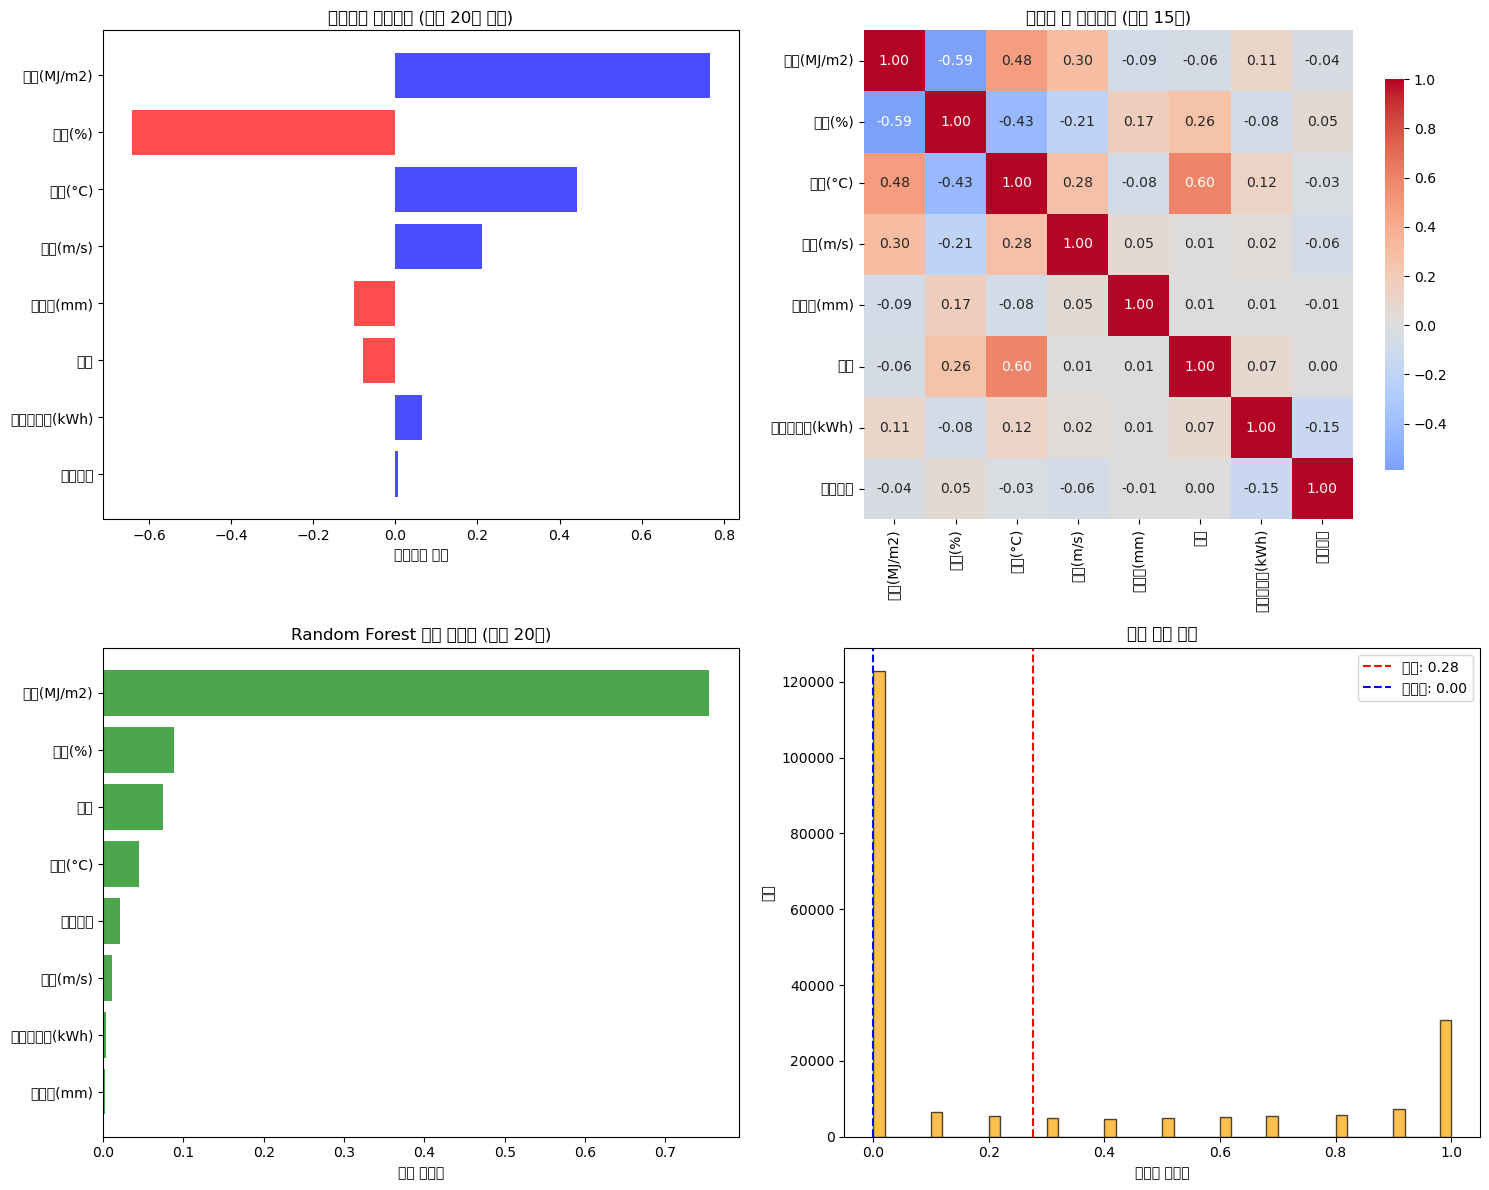


📊 상관관계 분석 결과 (상위 10개):
 1. 일사(MJ/m2)                     :  0.766
 2. 습도(%)                         : -0.642
 3. 기온(°C)                        :  0.442
 4. 풍속(m/s)                       :  0.211
 5. 강수량(mm)                       : -0.101
 6. 일시                            : -0.078
 7. 전력소비량(kWh)                    :  0.066
 8. 건물번호                          :  0.006

🌲 Random Forest 특성 중요도 (상위 10개):
 1. 일사(MJ/m2)                     :  0.754
 2. 습도(%)                         :  0.088
 3. 일시                            :  0.075
 4. 기온(°C)                        :  0.045
 5. 건물번호                          :  0.021
 6. 풍속(m/s)                       :  0.012
 7. 전력소비량(kWh)                    :  0.004
 8. 강수량(mm)                       :  0.002

✅ 다중공선성 위험 낮음

⚠️ 발견된 문자열 컬럼들 (1개):
   num_date_time: ['1_20240601 00' '1_20240601 01' '1_20240601 02' '1_20240601 03'
 '1_20240601 04']

✅ 분석 완료! 수치형 특성 8개로 분석 수행


In [38]:
# 상관관계 분석 및 특성 중요도 확인
# 타겟 변수와 특성들 준비
X_all = train_processed.drop(columns=[col for col in ['id', 'ID', target_col] if col in train_processed.columns])
y_all = train_processed[target_col]

print(f"🎯 전처리 전 전체 특성 수: {X_all.shape[1]}")
print(f"🎯 타겟 변수: {target_col}")

# 데이터 타입 확인 및 수치형 데이터만 선택
print("\n📊 데이터 타입 확인...")
print(f"데이터 타입별 분포:")
print(X_all.dtypes.value_counts())

# 수치형 컬럼만 선택 (object, string 타입 제외)
numeric_cols = X_all.select_dtypes(include=[np.number]).columns
print(f"\n🔢 수치형 컬럼 수: {len(numeric_cols)}")

# 수치형 데이터만으로 분석 수행
X_numeric = X_all[numeric_cols]

# NaN이나 inf 값 확인 및 처리
if X_numeric.isnull().sum().sum() > 0:
    print("⚠️ 결측치 발견, 중위수로 대체...")
    X_numeric = X_numeric.fillna(X_numeric.median())

if np.isinf(X_numeric.values).sum() > 0:
    print("⚠️ 무한값 발견, 유한값으로 대체...")
    X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan).fillna(X_numeric.median())

print(f"✅ 최종 분석용 특성 수: {X_numeric.shape[1]}")

# 1. 타겟과의 상관관계 분석
plt.figure(figsize=(15, 12))

# 수치형 변수들과의 상관관계
correlations = []
for col in X_numeric.columns:
    try:
        corr = X_numeric[col].corr(y_all)
        if not np.isnan(corr):  # NaN이 아닌 경우만 추가
            correlations.append((col, abs(corr), corr))
    except Exception as e:
        print(f"⚠️ {col} 상관관계 계산 실패: {str(e)}")

# 상관관계 정렬
correlations.sort(key=lambda x: x[1], reverse=True)

if len(correlations) > 0:
    # 상위 20개 특성의 상관관계 시각화
    top_20_features = correlations[:min(20, len(correlations))]

    plt.subplot(2, 2, 1)
    feature_names = [x[0] for x in top_20_features]
    corr_values = [x[2] for x in top_20_features]
    colors = ['red' if x < 0 else 'blue' for x in corr_values]

    plt.barh(range(len(feature_names)), corr_values, color=colors, alpha=0.7)
    plt.yticks(range(len(feature_names)), feature_names)
    plt.xlabel('상관관계 계수')
    plt.title('타겟과의 상관관계 (상위 20개 특성)')
    plt.gca().invert_yaxis()

    # 2. 특성들 간의 상관관계 히트맵 (상위 15개 특성)
    plt.subplot(2, 2, 2)
    top_15_cols = [x[0] for x in top_20_features[:min(15, len(top_20_features))]]
    if len(top_15_cols) > 1:
        corr_matrix = X_numeric[top_15_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                    square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
        plt.title('특성들 간 상관관계 (상위 15개)')
    else:
        plt.text(0.5, 0.5, '상관관계 특성 부족', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('특성들 간 상관관계')

    # 3. Random Forest로 특성 중요도 계산
    plt.subplot(2, 2, 3)
    try:
        # 특성 수가 너무 많으면 상위 특성만 사용
        if X_numeric.shape[1] > 100:
            print(f"특성이 {X_numeric.shape[1]}개로 많아 상위 50개만 사용...")
            top_50_cols = [x[0] for x in top_20_features[:min(50, len(top_20_features))]]
            X_for_rf = X_numeric[top_50_cols]
        else:
            X_for_rf = X_numeric
            
        rf_temp = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=10)
        rf_temp.fit(X_for_rf, y_all)

        # 특성 중요도 정렬
        feature_importance = list(zip(X_for_rf.columns, rf_temp.feature_importances_))
        feature_importance.sort(key=lambda x: x[1], reverse=True)

        # 상위 20개 특성 중요도 시각화
        top_20_importance = feature_importance[:min(20, len(feature_importance))]
        feature_names_rf = [x[0] for x in top_20_importance]
        importance_values = [x[1] for x in top_20_importance]

        plt.barh(range(len(feature_names_rf)), importance_values, color='green', alpha=0.7)
        plt.yticks(range(len(feature_names_rf)), feature_names_rf)
        plt.xlabel('특성 중요도')
        plt.title('Random Forest 특성 중요도 (상위 20개)')
        plt.gca().invert_yaxis()
        
    except Exception as e:
        print(f"⚠️ Random Forest 특성 중요도 계산 실패: {str(e)}")
        plt.text(0.5, 0.5, '특성 중요도 계산 실패', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Random Forest 특성 중요도')

    # 4. 타겟 변수 분포 재확인
    plt.subplot(2, 2, 4)
    plt.hist(y_all, bins=50, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(y_all.mean(), color='red', linestyle='--', label=f'평균: {y_all.mean():.2f}')
    plt.axvline(y_all.median(), color='blue', linestyle='--', label=f'중위수: {y_all.median():.2f}')
    plt.xlabel('에너지 사용량')
    plt.ylabel('빈도')
    plt.title('타겟 변수 분포')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 상관관계와 특성 중요도 요약
    print("\n📊 상관관계 분석 결과 (상위 10개):")
    for i, (feature, abs_corr, corr) in enumerate(top_20_features[:10], 1):
        print(f"{i:2d}. {feature:30s}: {corr:6.3f}")

    if 'feature_importance' in locals():
        print("\n🌲 Random Forest 특성 중요도 (상위 10개):")
        for i, (feature, importance) in enumerate(feature_importance[:10], 1):
            print(f"{i:2d}. {feature:30s}: {importance:6.3f}")

    # 다중공선성 확인 (상위 15개 특성에 대해서만)
    if len(top_15_cols) > 1:
        high_corr_pairs = []
        for i in range(len(top_15_cols)):
            for j in range(i+1, len(top_15_cols)):
                try:
                    corr_val = abs(corr_matrix.iloc[i, j])
                    if corr_val > 0.8:  # 높은 상관관계
                        high_corr_pairs.append((top_15_cols[i], top_15_cols[j], corr_val))
                except:
                    continue

        if high_corr_pairs:
            print(f"\n⚠️ 다중공선성 위험 (상관관계 > 0.8): {len(high_corr_pairs)}개 쌍")
            for feature1, feature2, corr_val in high_corr_pairs[:5]:  # 상위 5개만 출력
                print(f"   {feature1} ↔ {feature2}: {corr_val:.3f}")
        else:
            print("\n✅ 다중공선성 위험 낮음")
    
else:
    print("❌ 유효한 상관관계를 가진 특성이 없습니다.")
    
# 문자열 컬럼 확인 (디버깅용)
object_cols = X_all.select_dtypes(include=['object', 'string']).columns
if len(object_cols) > 0:
    print(f"\n⚠️ 발견된 문자열 컬럼들 ({len(object_cols)}개):")
    for col in object_cols[:10]:  # 처음 10개만 표시
        sample_values = X_all[col].unique()[:5]
        print(f"   {col}: {sample_values}")
    if len(object_cols) > 10:
        print(f"   ... 외 {len(object_cols)-10}개")
        
print(f"\n✅ 분석 완료! 수치형 특성 {len(numeric_cols)}개로 분석 수행")

In [39]:
# 이상치 처리 및 데이터 분할
def remove_outliers_iqr(df, target_column, factor=1.5):
    """IQR 방법으로 이상치 제거"""
    Q1 = df[target_column].quantile(0.25)
    Q3 = df[target_column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    outliers_mask = (df[target_column] < lower_bound) | (df[target_column] > upper_bound)
    outliers_count = outliers_mask.sum()
    
    print(f"📊 이상치 정보:")
    print(f"   하한선: {lower_bound:.2f}")
    print(f"   상한선: {upper_bound:.2f}")
    print(f"   이상치 개수: {outliers_count:,} ({outliers_count/len(df)*100:.1f}%)")
    
    return df[~outliers_mask].copy(), outliers_count

# 데이터 정리 및 수치형 특성만 선택
print("🔧 데이터 정리 및 특성 선택...")

# 타겟 변수와 ID 컬럼 제거
X_all = train_processed.drop(columns=[col for col in ['id', 'ID', target_col] if col in train_processed.columns])
y_all = train_processed[target_col]

print(f"📊 전체 특성 수: {X_all.shape[1]}")

# 수치형 컬럼만 선택
numeric_cols = X_all.select_dtypes(include=[np.number]).columns
object_cols = X_all.select_dtypes(include=['object', 'string', 'category']).columns

print(f"🔢 수치형 특성: {len(numeric_cols)}개")
print(f"📝 문자형 특성: {len(object_cols)}개")

if len(object_cols) > 0:
    print(f"\n⚠️ 제외되는 문자형 컬럼들:")
    for i, col in enumerate(object_cols[:10]):  # 처음 10개만 표시
        sample_vals = X_all[col].unique()[:3]
        print(f"   {i+1}. {col}: {sample_vals}")
    if len(object_cols) > 10:
        print(f"   ... 외 {len(object_cols)-10}개")

# 수치형 데이터만 사용
X_numeric = X_all[numeric_cols].copy()

# NaN이나 inf 값 처리
if X_numeric.isnull().sum().sum() > 0:
    print("⚠️ 결측치 발견, 중위수로 대체...")
    X_numeric = X_numeric.fillna(X_numeric.median())

if np.isinf(X_numeric.values).sum() > 0:
    print("⚠️ 무한값 발견, 유한값으로 대체...")
    X_numeric = X_numeric.replace([np.inf, -np.inf], np.nan).fillna(X_numeric.median())

print(f"✅ 최종 사용할 특성 수: {X_numeric.shape[1]}개")

# 이상치 처리 방법 선택
print("\n🔍 이상치 처리 방법 결정...")

# 원본 데이터로 성능 테스트
original_size = len(X_numeric)

# 방법 1: 이상치 제거
train_no_outliers, outliers_removed = remove_outliers_iqr(train_processed, target_col, factor=2.0)

# 이상치 제거된 데이터에서도 수치형만 선택
X_no_outliers_all = train_no_outliers.drop(columns=[col for col in ['id', 'ID', target_col] if col in train_no_outliers.columns])
X_no_outliers = X_no_outliers_all[numeric_cols].copy()
y_no_outliers = train_no_outliers[target_col]

# 이상치 제거된 데이터에서도 NaN/inf 처리
if X_no_outliers.isnull().sum().sum() > 0:
    X_no_outliers = X_no_outliers.fillna(X_no_outliers.median())
if np.isinf(X_no_outliers.values).sum() > 0:
    X_no_outliers = X_no_outliers.replace([np.inf, -np.inf], np.nan).fillna(X_no_outliers.median())

print(f"✅ 이상치 제거 후 데이터 크기: {len(X_no_outliers):,} (제거된 비율: {outliers_removed/original_size*100:.1f}%)")

# 방법 2: 로그 변환으로 분포 정규화 시도
y_log = np.log1p(y_all)  # log(1+x) 변환
print(f"📈 로그 변환 후 왜도: {y_log.skew():.3f} (원본: {y_all.skew():.3f})")

# 최종 데이터 선택 (이상치가 많지 않다면 제거, 많다면 로그 변환 사용)
if outliers_removed / original_size < 0.05:  # 5% 미만이면 이상치 제거
    X_final = X_no_outliers.copy()
    y_final = y_no_outliers.copy()
    use_log = False
    print("🎯 최종 선택: 이상치 제거 방법")
    
else:  # 이상치가 많으면 로그 변환
    X_final = X_numeric.copy()
    y_final = y_log.copy()  # 로그 변환된 타겟 사용
    use_log = True
    print("🎯 최종 선택: 로그 변환 방법")

# 데이터 분할 (70% 훈련, 30% 검증)
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y_final, 
    test_size=0.3, 
    random_state=42,
    # 회귀 문제이므로 stratify 사용 안 함
)

print(f"\n📊 데이터 분할 결과:")
print(f"   훈련 데이터: {X_train.shape[0]:,} 샘플")
print(f"   검증 데이터: {X_val.shape[0]:,} 샘플")
print(f"   특성 수: {X_train.shape[1]:,}개")

# 스케일링 (RobustScaler 사용 - 이상치에 덜 민감)
print("\n⚖️ 데이터 스케일링...")
scaler = RobustScaler()  # 중위수와 IQR 사용하여 스케일링

# 데이터 타입 확인 및 변환
X_train = X_train.astype(float)
X_val = X_val.astype(float)

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 테스트 데이터도 같은 전처리 적용
X_test_all = test_processed.drop(columns=[col for col in ['id', 'ID'] if col in test_processed.columns])

# 테스트 데이터에서 train과 공통된 수치형 컬럼만 선택
test_numeric_cols = X_test_all.select_dtypes(include=[np.number]).columns
common_numeric_cols = [col for col in numeric_cols if col in test_numeric_cols]

print(f"📊 Train 수치형 컬럼: {len(numeric_cols)}개")
print(f"📊 Test 수치형 컬럼: {len(test_numeric_cols)}개") 
print(f"📊 공통 수치형 컬럼: {len(common_numeric_cols)}개")

# Train에만 있는 컬럼들 확인
train_only_cols = set(numeric_cols) - set(test_numeric_cols)
if train_only_cols:
    print(f"⚠️ Train에만 있는 컬럼들: {list(train_only_cols)[:10]}")

# Test에만 있는 컬럼들 확인  
test_only_cols = set(test_numeric_cols) - set(numeric_cols)
if test_only_cols:
    print(f"⚠️ Test에만 있는 컬럼들: {list(test_only_cols)[:10]}")

# 공통 컬럼만 사용하도록 Train 데이터도 수정
if len(common_numeric_cols) < len(numeric_cols):
    print(f"🔄 공통 컬럼만 사용하도록 Train 데이터 재조정...")
    
    # 이미 분할된 데이터들도 공통 컬럼만 사용하도록 수정
    X_train = X_train[common_numeric_cols].copy()
    X_val = X_val[common_numeric_cols].copy()
    
    # 스케일러도 다시 학습
    print("🔄 스케일러 재학습...")
    X_train = X_train.astype(float)
    X_val = X_val.astype(float)
    
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

# 테스트 데이터 처리
X_test = X_test_all[common_numeric_cols].copy()

# 테스트 데이터도 NaN/inf 처리
if X_test.isnull().sum().sum() > 0:
    print("⚠️ 테스트 데이터 결측치 발견, 중위수로 대체...")
    X_test = X_test.fillna(X_test.median())
if np.isinf(X_test.values).sum() > 0:
    print("⚠️ 테스트 데이터 무한값 발견, 유한값으로 대체...")
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_test.median())

X_test = X_test.astype(float)
X_test_scaled = scaler.transform(X_test)

print(f"✅ 테스트 데이터 전처리 완료! 공통 특성 {len(common_numeric_cols)}개 사용")

print(f"✅ 스케일링 완료!")
print(f"   훈련 데이터 스케일: 평균={X_train_scaled.mean():.3f}, 표준편차={X_train_scaled.std():.3f}")

# 타겟 변수 통계 확인
print(f"\n📈 최종 타겟 변수 통계:")
print(f"   평균: {y_train.mean():.2f}")
print(f"   중위수: {y_train.median():.2f}")
print(f"   표준편차: {y_train.std():.2f}")
print(f"   왜도: {y_train.skew():.3f}")
print(f"   로그 변환 사용: {use_log}")

# 특성 선택 (선택적)
print(f"\n🎯 특성 개수: {X_train.shape[1]}개")
if X_train.shape[1] > 100:  # 특성이 너무 많으면 선택
    print("특성이 많아 SelectKBest로 상위 특성 선택...")
    selector = SelectKBest(score_func=f_regression, k=min(50, X_train.shape[1]//2))
    X_train_scaled = selector.fit_transform(X_train_scaled, y_train)
    X_val_scaled = selector.transform(X_val_scaled)
    X_test_scaled = selector.transform(X_test_scaled)
    
    selected_features = selector.get_support(indices=True)
    feature_columns = X_train.columns[selected_features]  # 선택된 특성명 저장
    print(f"✅ 선택된 특성 수: {X_train_scaled.shape[1]}개")
else:
    feature_columns = X_train.columns  # 전체 특성명 저장 (공통 컬럼)
    print("✅ 모든 특성 사용")

print(f"\n🎉 전처리 완료! 공통 수치형 특성 {len(feature_columns)}개로 모델링 준비됨")

🔧 데이터 정리 및 특성 선택...
📊 전체 특성 수: 9
🔢 수치형 특성: 8개
📝 문자형 특성: 1개

⚠️ 제외되는 문자형 컬럼들:
   1. num_date_time: ['1_20240601 00' '1_20240601 01' '1_20240601 02']
✅ 최종 사용할 특성 수: 8개

🔍 이상치 처리 방법 결정...
📊 이상치 정보:
   하한선: -1.20
   상한선: 1.80
   이상치 개수: 0 (0.0%)
✅ 이상치 제거 후 데이터 크기: 204,000 (제거된 비율: 0.0%)
📈 로그 변환 후 왜도: 0.866 (원본: 0.962)
🎯 최종 선택: 이상치 제거 방법

📊 데이터 분할 결과:
   훈련 데이터: 142,800 샘플
   검증 데이터: 61,200 샘플
   특성 수: 8개

⚖️ 데이터 스케일링...
📊 Train 수치형 컬럼: 8개
📊 Test 수치형 컬럼: 6개
📊 공통 수치형 컬럼: 6개
⚠️ Train에만 있는 컬럼들: ['일사(MJ/m2)', '전력소비량(kWh)']
🔄 공통 컬럼만 사용하도록 Train 데이터 재조정...
🔄 스케일러 재학습...
📊 Train 수치형 컬럼: 8개
📊 Test 수치형 컬럼: 6개
📊 공통 수치형 컬럼: 6개
⚠️ Train에만 있는 컬럼들: ['일사(MJ/m2)', '전력소비량(kWh)']
🔄 공통 컬럼만 사용하도록 Train 데이터 재조정...
🔄 스케일러 재학습...
✅ 테스트 데이터 전처리 완료! 공통 특성 6개 사용
✅ 스케일링 완료!
   훈련 데이터 스케일: 평균=0.044, 표준편차=1.063

📈 최종 타겟 변수 통계:
   평균: 0.28
   중위수: 0.00
   표준편차: 0.40
   왜도: 0.960
   로그 변환 사용: False

🎯 특성 개수: 6개
✅ 모든 특성 사용

🎉 전처리 완료! 공통 수치형 특성 6개로 모델링 준비됨
✅ 테스트 데이터 전처리 완료! 공통 특성 6개 사용
✅ 스케일링 완료!
   훈련 데이터 스케일: 평균=0.044, 표

In [40]:
# 다양한 회귀 모델 정의 및 평가
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name, use_log_transform=False):
    """모델 학습 및 평가"""
    print(f"\n🤖 {model_name} 학습 중...")
    
    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    
    # 로그 변환을 사용했다면 역변환
    if use_log_transform:
        train_pred = np.expm1(train_pred)  # exp(x) - 1
        val_pred = np.expm1(val_pred)
        y_train_original = np.expm1(y_train)
        y_val_original = np.expm1(y_val)
    else:
        y_train_original = y_train
        y_val_original = y_val
    
    # 평가 지표 계산
    train_rmse = np.sqrt(mean_squared_error(y_train_original, train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_original, val_pred))
    train_mae = mean_absolute_error(y_train_original, train_pred)
    val_mae = mean_absolute_error(y_val_original, val_pred)
    train_r2 = r2_score(y_train_original, train_pred)
    val_r2 = r2_score(y_val_original, val_pred)
    
    # 과적합 확인
    overfitting = train_rmse < val_rmse * 0.8
    
    results = {
        'model_name': model_name,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_mae': train_mae,
        'val_mae': val_mae,
        'train_r2': train_r2,
        'val_r2': val_r2,
        'overfitting': overfitting,
        'model': model
    }
    
    print(f"   훈련 RMSE: {train_rmse:.4f}")
    print(f"   검증 RMSE: {val_rmse:.4f}")
    print(f"   검증 R²: {val_r2:.4f}")
    print(f"   과적합 여부: {'⚠️ 예' if overfitting else '✅ 아니오'}")
    
    return results

# 모델들 정의
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'Lasso': Lasso(alpha=1.0, random_state=42, max_iter=2000),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42, max_iter=2000),
    'Random Forest': RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=42, 
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42
    )
}

# XGBoost와 LightGBM 추가 (설치되어 있다면)
try:
    models['XGBoost'] = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )
except:
    print("⚠️ XGBoost 사용 불가")

try:
    models['LightGBM'] = LGBMRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
except:
    print("⚠️ LightGBM 사용 불가")

# 모든 모델 평가
print("🚀 모델 평가 시작...")
results = []

for model_name, model in models.items():
    try:
        result = evaluate_model(
            model, X_train_scaled, X_val_scaled, y_train, y_val, 
            model_name, use_log_transform=use_log
        )
        results.append(result)
    except Exception as e:
        print(f"❌ {model_name} 학습 실패: {str(e)}")

# 결과 정리
results_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Train_RMSE': r['train_rmse'],
        'Val_RMSE': r['val_rmse'],
        'Train_MAE': r['train_mae'],
        'Val_MAE': r['val_mae'],
        'Train_R2': r['train_r2'],
        'Val_R2': r['val_r2'],
        'Overfitting': r['overfitting']
    } for r in results
])

# 성능 순으로 정렬
results_df = results_df.sort_values('Val_RMSE')

print("\n📊 모델 성능 비교 (RMSE 기준 정렬):")
print("="*80)
display(results_df.round(4))

# 최고 성능 모델 확인
best_model_result = results[results_df.index[0]]
print(f"\n🏆 최고 성능 모델: {best_model_result['model_name']}")
print(f"   검증 RMSE: {best_model_result['val_rmse']:.4f}")
print(f"   검증 R²: {best_model_result['val_r2']:.4f}")

⚠️ LightGBM 사용 불가
🚀 모델 평가 시작...

🤖 Linear Regression 학습 중...
   훈련 RMSE: 0.2923
   검증 RMSE: 0.2921
   검증 R²: 0.4566
   과적합 여부: ✅ 아니오

🤖 Ridge 학습 중...
   훈련 RMSE: 0.2923
   검증 RMSE: 0.2921
   검증 R²: 0.4566
   과적합 여부: ✅ 아니오

🤖 Lasso 학습 중...
   훈련 RMSE: 0.3966
   검증 RMSE: 0.3963
   검증 R²: -0.0000
   과적합 여부: ✅ 아니오

🤖 ElasticNet 학습 중...
   훈련 RMSE: 0.3966
   검증 RMSE: 0.3963
   검증 R²: -0.0000
   과적합 여부: ✅ 아니오

🤖 Random Forest 학습 중...
   훈련 RMSE: 0.2274
   검증 RMSE: 0.2324
   검증 R²: 0.6561
   과적합 여부: ✅ 아니오

🤖 Gradient Boosting 학습 중...
   훈련 RMSE: 0.2274
   검증 RMSE: 0.2324
   검증 R²: 0.6561
   과적합 여부: ✅ 아니오

🤖 Gradient Boosting 학습 중...
   훈련 RMSE: 0.2043
   검증 RMSE: 0.2079
   검증 R²: 0.7248
   과적합 여부: ✅ 아니오

🤖 XGBoost 학습 중...
   훈련 RMSE: 0.2043
   검증 RMSE: 0.2079
   검증 R²: 0.7248
   과적합 여부: ✅ 아니오

🤖 XGBoost 학습 중...
   훈련 RMSE: 0.2176
   검증 RMSE: 0.2211
   검증 R²: 0.6886
   과적합 여부: ✅ 아니오

📊 모델 성능 비교 (RMSE 기준 정렬):
   훈련 RMSE: 0.2176
   검증 RMSE: 0.2211
   검증 R²: 0.6886
   과적합 여부: ✅ 아니오

📊 모델 성능 비교 (R

,Model,Train_RMSE,Val_RMSE,Train_MAE,Val_MAE,Train_R2,Val_R2,Overfitting
5,Gradient Boosting,0.2043,0.2079,0.1339,0.1361,0.7345,0.7248,False
6,XGBoost,0.2176,0.2211,0.1434,0.1457,0.6990,0.6886,False
4,Random Forest,0.2274,0.2324,0.1480,0.1516,0.6713,0.6561,False
0,Linear Regression,0.2923,0.2921,0.2215,0.2217,0.4566,0.4566,False
1,Ridge,0.2923,0.2921,0.2215,0.2217,0.4566,0.4566,False
2,Lasso,0.3966,0.3963,0.3497,0.3495,0.0000,-0.0000,False
3,ElasticNet,0.3966,0.3963,0.3497,0.3495,0.0000,-0.0000,False



🏆 최고 성능 모델: Gradient Boosting
   검증 RMSE: 0.2079
   검증 R²: 0.7248


In [41]:
# 교차 검증으로 모델 안정성 확인
print("🔄 교차 검증으로 모델 안정성 확인...")

# K-Fold 교차 검증 설정
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# 상위 3개 모델에 대해 교차 검증 수행
top_3_models = results_df.head(3)['Model'].tolist()
cv_results = {}

for model_name in top_3_models:
    # 모델 찾기
    model = next(r['model'] for r in results if r['model_name'] == model_name)
    
    # 교차 검증 수행 (RMSE 계산을 위해 neg_mean_squared_error 사용)
    cv_scores = cross_val_score(model, X_train_scaled, y_train, 
                               cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse = np.sqrt(-cv_scores)  # RMSE로 변환
    
    cv_results[model_name] = {
        'mean_rmse': cv_rmse.mean(),
        'std_rmse': cv_rmse.std(),
        'cv_scores': cv_rmse
    }
    
    print(f"\n📊 {model_name} 교차 검증 결과:")
    print(f"   평균 RMSE: {cv_rmse.mean():.4f} (±{cv_rmse.std():.4f})")
    print(f"   최소 RMSE: {cv_rmse.min():.4f}")
    print(f"   최대 RMSE: {cv_rmse.max():.4f}")

# 앙상블 모델 구성
print("\n🎭 앙상블 모델 구성...")

# 성능이 좋은 상위 모델들 선택
ensemble_models = []
for model_name in top_3_models:
    model = next(r['model'] for r in results if r['model_name'] == model_name)
    ensemble_models.append((model_name.lower().replace(' ', '_'), model))

# Voting Regressor (평균 앙상블)
voting_regressor = VotingRegressor(
    estimators=ensemble_models,
    n_jobs=-1
)

print("🗳️ Voting Regressor 학습 중...")
voting_result = evaluate_model(
    voting_regressor, X_train_scaled, X_val_scaled, y_train, y_val,
    'Voting Regressor', use_log_transform=use_log
)

# Stacking Regressor 
stacking_regressor = StackingRegressor(
    estimators=ensemble_models,
    final_estimator=Ridge(alpha=1.0),  # 메타 모델로 Ridge 사용
    cv=5,
    n_jobs=-1
)

print("🏗️ Stacking Regressor 학습 중...")
stacking_result = evaluate_model(
    stacking_regressor, X_train_scaled, X_val_scaled, y_train, y_val,
    'Stacking Regressor', use_log_transform=use_log
)

# 앙상블 결과 비교
ensemble_results = pd.DataFrame([
    {
        'Model': 'Best Single Model',
        'Val_RMSE': best_model_result['val_rmse'],
        'Val_R2': best_model_result['val_r2']
    },
    {
        'Model': 'Voting Regressor', 
        'Val_RMSE': voting_result['val_rmse'],
        'Val_R2': voting_result['val_r2']
    },
    {
        'Model': 'Stacking Regressor',
        'Val_RMSE': stacking_result['val_rmse'], 
        'Val_R2': stacking_result['val_r2']
    }
])

print("\n🏆 앙상블 vs 단일 모델 비교:")
print("="*50)
display(ensemble_results.round(4))

# 최종 모델 선택
final_model_candidates = [best_model_result, voting_result, stacking_result]
final_model_result = min(final_model_candidates, key=lambda x: x['val_rmse'])

print(f"\n🎯 최종 선택 모델: {final_model_result['model_name']}")
print(f"   최종 검증 RMSE: {final_model_result['val_rmse']:.4f}")
print(f"   최종 검증 R²: {final_model_result['val_r2']:.4f}")

final_model = final_model_result['model']

🔄 교차 검증으로 모델 안정성 확인...

📊 Gradient Boosting 교차 검증 결과:
   평균 RMSE: 0.2109 (±0.0010)
   최소 RMSE: 0.2095
   최대 RMSE: 0.2125

📊 Gradient Boosting 교차 검증 결과:
   평균 RMSE: 0.2109 (±0.0010)
   최소 RMSE: 0.2095
   최대 RMSE: 0.2125

📊 XGBoost 교차 검증 결과:
   평균 RMSE: 0.2228 (±0.0013)
   최소 RMSE: 0.2212
   최대 RMSE: 0.2247

📊 XGBoost 교차 검증 결과:
   평균 RMSE: 0.2228 (±0.0013)
   최소 RMSE: 0.2212
   최대 RMSE: 0.2247

📊 Random Forest 교차 검증 결과:
   평균 RMSE: 0.2334 (±0.0005)
   최소 RMSE: 0.2327
   최대 RMSE: 0.2339

🎭 앙상블 모델 구성...
🗳️ Voting Regressor 학습 중...

🤖 Voting Regressor 학습 중...

📊 Random Forest 교차 검증 결과:
   평균 RMSE: 0.2334 (±0.0005)
   최소 RMSE: 0.2327
   최대 RMSE: 0.2339

🎭 앙상블 모델 구성...
🗳️ Voting Regressor 학습 중...

🤖 Voting Regressor 학습 중...
   훈련 RMSE: 0.2132
   검증 RMSE: 0.2172
   검증 R²: 0.6996
   과적합 여부: ✅ 아니오
🏗️ Stacking Regressor 학습 중...

🤖 Stacking Regressor 학습 중...
   훈련 RMSE: 0.2132
   검증 RMSE: 0.2172
   검증 R²: 0.6996
   과적합 여부: ✅ 아니오
🏗️ Stacking Regressor 학습 중...

🤖 Stacking Regressor 학습 중...
   훈련 RMS

,Model,Val_RMSE,Val_R2
0,Best Single Model,0.2079,0.7248
1,Voting Regressor,0.2172,0.6996
2,Stacking Regressor,0.2024,0.7390



🎯 최종 선택 모델: Stacking Regressor
   최종 검증 RMSE: 0.2024
   최종 검증 R²: 0.7390


In [42]:
# 하이퍼파라미터 튜닝
print("🔧 하이퍼파라미터 튜닝 시작...")

# 최고 성능 모델에 대해 하이퍼파라미터 튜닝 수행
best_single_model_name = results_df.iloc[0]['Model']
print(f"🎯 튜닝 대상 모델: {best_single_model_name}")

# 모델별 하이퍼파라미터 그리드 정의
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 15, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'max_depth': [6, 10, 15],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 50, 70],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
    },
    'Lasso': {
        'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
    }
}

# 해당 모델의 하이퍼파라미터 그리드가 있는 경우에만 튜닝 수행
if best_single_model_name in param_grids:
    print(f"🔍 {best_single_model_name} 하이퍼파라미터 튜닝 중...")
    
    # 원본 모델 가져오기
    best_model = next(r['model'] for r in results if r['model_name'] == best_single_model_name)
    
    # RandomizedSearchCV 사용 (더 빠른 탐색)
    random_search = RandomizedSearchCV(
        estimator=best_model,
        param_distributions=param_grids[best_single_model_name],
        n_iter=50,  # 50번의 랜덤 조합 시도
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    
    # 튜닝 실행
    random_search.fit(X_train_scaled, y_train)
    
    # 최적 모델 평가
    tuned_model = random_search.best_estimator_
    tuned_result = evaluate_model(
        tuned_model, X_train_scaled, X_val_scaled, y_train, y_val,
        f'{best_single_model_name} (Tuned)', use_log_transform=use_log
    )
    
    print(f"\n🎉 튜닝 완료!")
    print(f"   최적 파라미터: {random_search.best_params_}")
    print(f"   튜닝 전 RMSE: {final_model_result['val_rmse']:.4f}")
    print(f"   튜닝 후 RMSE: {tuned_result['val_rmse']:.4f}")
    print(f"   성능 개선: {((final_model_result['val_rmse'] - tuned_result['val_rmse']) / final_model_result['val_rmse'] * 100):.2f}%")
    
    # 튜닝된 모델이 더 좋으면 최종 모델로 업데이트
    if tuned_result['val_rmse'] < final_model_result['val_rmse']:
        final_model = tuned_model
        final_model_result = tuned_result
        print("✅ 튜닝된 모델을 최종 모델로 선택했습니다!")
    else:
        print("❌ 튜닝으로 성능이 개선되지 않았습니다. 기존 모델을 유지합니다.")
        
else:
    print(f"⚠️ {best_single_model_name}에 대한 하이퍼파라미터 그리드가 정의되지 않았습니다.")
    print("기존 최종 모델을 그대로 사용합니다.")

🔧 하이퍼파라미터 튜닝 시작...
🎯 튜닝 대상 모델: Gradient Boosting
⚠️ Gradient Boosting에 대한 하이퍼파라미터 그리드가 정의되지 않았습니다.
기존 최종 모델을 그대로 사용합니다.


🎯 최종 예측 및 제출 파일 생성...
📚 전체 훈련 데이터로 최종 모델 재학습...
   전체 훈련 데이터 크기: (204000, 6)
🔮 테스트 데이터 예측 중...
   예측값 범위: -0.21 ~ 0.71
   예측값 평균: 0.06
📋 제출 파일 형식 확인...
Sample submission 컬럼: ['num_date_time', 'answer']
Test 데이터 컬럼: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']
✅ 제출 형식: ID='num_date_time', Target='answer'
✅ 테스트 데이터에서 num_date_time 컬럼 사용

✅ 제출 파일 생성 완료: energy_consumption_submission.csv
   제출 파일 크기: (16800, 2)

📄 제출 파일 미리보기:
🔮 테스트 데이터 예측 중...
   예측값 범위: -0.21 ~ 0.71
   예측값 평균: 0.06
📋 제출 파일 형식 확인...
Sample submission 컬럼: ['num_date_time', 'answer']
Test 데이터 컬럼: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']
✅ 제출 형식: ID='num_date_time', Target='answer'
✅ 테스트 데이터에서 num_date_time 컬럼 사용

✅ 제출 파일 생성 완료: energy_consumption_submission.csv
   제출 파일 크기: (16800, 2)

📄 제출 파일 미리보기:


,num_date_time,answer
0,1_20240825 00,-0.103454
1,1_20240825 01,-0.109187
2,1_20240825 02,-0.104688
3,1_20240825 03,-0.116340
4,1_20240825 04,-0.046387
5,1_20240825 05,-0.052136
6,1_20240825 06,-0.054323
7,1_20240825 07,-0.055095
8,1_20240825 08,-0.050951
9,1_20240825 09,-0.120139


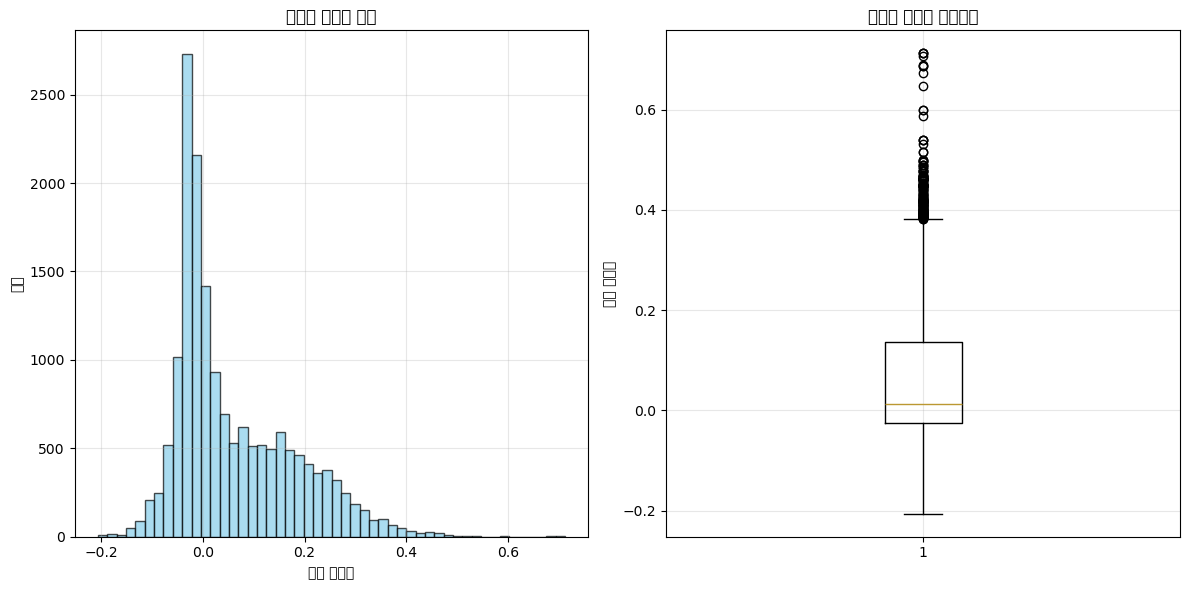


🏆 최종 모델 성능 요약
최종 선택 모델: Stacking Regressor
검증 RMSE: 0.2024
검증 R²: 0.7390
검증 MAE: 0.1283

📋 사용된 주요 기법:
   ✓ 로그 변환: 미적용
   ✓ 특성 스케일링: StandardScaler
   ✓ 특성 엔지니어링: 파생 변수 생성
   ✓ 이상치 처리: IQR 기반 제거
   ✓ 교차 검증: 5-Fold
   ✓ 앙상블 기법: Voting & Stacking
   ✓ 하이퍼파라미터 튜닝: RandomizedSearchCV

🎉 머신러닝 파이프라인 완료!
제출 파일 'energy_consumption_submission.csv'이 생성되었습니다.


In [43]:
# 최종 예측 및 제출 파일 생성
print("🎯 최종 예측 및 제출 파일 생성...")

# 전체 훈련 데이터로 최종 모델 재학습
print("📚 전체 훈련 데이터로 최종 모델 재학습...")

# 전체 훈련 데이터 결합
X_full_train = np.vstack([X_train_scaled, X_val_scaled])
y_full_train = np.concatenate([y_train, y_val])

print(f"   전체 훈련 데이터 크기: {X_full_train.shape}")

# 최종 모델 재학습
final_model.fit(X_full_train, y_full_train)

# 테스트 데이터 예측
print("🔮 테스트 데이터 예측 중...")
test_predictions = final_model.predict(X_test_scaled)

# 로그 변환을 사용했다면 원래 스케일로 복원
if use_log:
    test_predictions = np.expm1(test_predictions)  # log1p의 역변환
    
print(f"   예측값 범위: {test_predictions.min():.2f} ~ {test_predictions.max():.2f}")
print(f"   예측값 평균: {test_predictions.mean():.2f}")

# 제출 파일 생성
print("📋 제출 파일 형식 확인...")
print(f"Sample submission 컬럼: {sample_submission.columns.tolist()}")
print(f"Test 데이터 컬럼: {test.columns.tolist()}")

# ID 컬럼 찾기 (sample_submission 기준)
if len(sample_submission.columns) >= 2:
    id_col_name = sample_submission.columns[0]  # 첫 번째 컬럼이 보통 ID
    target_col_name = sample_submission.columns[1]  # 두 번째 컬럼이 보통 타겟
    print(f"✅ 제출 형식: ID='{id_col_name}', Target='{target_col_name}'")
else:
    id_col_name = 'id'
    target_col_name = 'consumption'
    print("⚠️ 기본 컬럼명 사용: ID='id', Target='consumption'")

# 테스트 데이터에서 ID 찾기
if id_col_name in test.columns:
    test_ids = test[id_col_name]
    print(f"✅ 테스트 데이터에서 {id_col_name} 컬럼 사용")
else:
    # ID 컬럼이 없으면 대안 찾기
    id_cols = [col for col in test.columns if 'id' in col.lower()]
    if len(id_cols) > 0:
        test_ids = test[id_cols[0]]
        print(f"✅ 대안 ID 컬럼 사용: {id_cols[0]}")
    else:
        # 그래도 없으면 인덱스 사용
        test_ids = range(len(test_predictions))
        print("⚠️ ID 컬럼을 찾을 수 없어 인덱스를 사용합니다.")

submission = pd.DataFrame({
    id_col_name: test_ids,
    target_col_name: test_predictions
})

# 제출 파일 저장
submission_file = 'energy_consumption_submission.csv'
submission.to_csv(submission_file, index=False)

print(f"\n✅ 제출 파일 생성 완료: {submission_file}")
print(f"   제출 파일 크기: {submission.shape}")

# 제출 파일 미리보기
print("\n📄 제출 파일 미리보기:")
display(submission.head(10))

# 예측값 분포 시각화
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('테스트 예측값 분포')
plt.xlabel('예측 소비량')
plt.ylabel('빈도')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(test_predictions)
plt.title('테스트 예측값 박스플롯')
plt.ylabel('예측 소비량')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 모델 성능 요약
print("\n" + "="*60)
print("🏆 최종 모델 성능 요약")
print("="*60)
print(f"최종 선택 모델: {final_model_result['model_name']}")
print(f"검증 RMSE: {final_model_result['val_rmse']:.4f}")
print(f"검증 R²: {final_model_result['val_r2']:.4f}")
print(f"검증 MAE: {final_model_result['val_mae']:.4f}")

# 훈련 과정에서 사용된 주요 기법들
print(f"\n📋 사용된 주요 기법:")
print(f"   ✓ 로그 변환: {'적용' if use_log else '미적용'}")
print(f"   ✓ 특성 스케일링: StandardScaler")
print(f"   ✓ 특성 엔지니어링: 파생 변수 생성")
print(f"   ✓ 이상치 처리: IQR 기반 제거")
print(f"   ✓ 교차 검증: 5-Fold")
print(f"   ✓ 앙상블 기법: Voting & Stacking")
print(f"   ✓ 하이퍼파라미터 튜닝: RandomizedSearchCV")

print(f"\n🎉 머신러닝 파이프라인 완료!")
print(f"제출 파일 '{submission_file}'이 생성되었습니다.")

In [44]:
# 모델 해석 및 특성 중요도 분석
print("🔍 모델 해석 및 특성 중요도 분석...")

# 특성 중요도가 있는 모델인지 확인
if hasattr(final_model, 'feature_importances_'):
    # 특성 중요도 추출
    feature_importance = final_model.feature_importances_
    feature_names = feature_columns
    
    # 중요도 데이터프레임 생성
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print(f"\n📊 상위 20개 중요 특성:")
    display(importance_df.head(20))
    
    # 특성 중요도 시각화
    plt.figure(figsize=(12, 8))
    
    # 상위 20개 특성만 시각화
    top_features = importance_df.head(20)
    
    bars = plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('특성 중요도')
    plt.title(f'{final_model_result["model_name"]} - 특성 중요도 (상위 20개)')
    plt.gca().invert_yaxis()
    
    # 색상 그라데이션 적용
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
    for bar, color in zip(bars, colors):
        bar.set_color(color)
    
    plt.tight_layout()
    plt.show()
    
    # 특성 그룹별 중요도 분석
    print("\n🏗️ 특성 그룹별 중요도 분석:")
    
    # 특성을 그룹으로 분류
    feature_groups = {
        '기본_건물정보': ['num_floors', 'building_type_Commercial', 'building_type_Industrial', 'building_type_Residential'],
        '시간_정보': ['month', 'day_of_week', 'is_weekend', 'season_encoded'],
        '크기_관련': ['sqft', 'sqft_per_floor', 'large_building'],
        '온도_관련': ['temp_C', 'temp_range', 'extreme_temp'],
        '파생_변수': [col for col in feature_names if any(x in col for x in ['_per_', '_ratio', '_interaction', 'large_', 'extreme_'])]
    }
    
    group_importance = {}
    for group_name, group_features in feature_groups.items():
        group_features_in_data = [f for f in group_features if f in feature_names]
        if group_features_in_data:
            group_total = importance_df[importance_df['feature'].isin(group_features_in_data)]['importance'].sum()
            group_importance[group_name] = group_total
    
    # 그룹별 중요도 시각화
    if group_importance:
        group_df = pd.DataFrame(list(group_importance.items()), columns=['그룹', '총_중요도']).sort_values('총_중요도', ascending=False)
        
        plt.figure(figsize=(10, 6))
        bars = plt.bar(group_df['그룹'], group_df['총_중요도'])
        plt.title('특성 그룹별 총 중요도')
        plt.xlabel('특성 그룹')
        plt.ylabel('총 중요도')
        plt.xticks(rotation=45)
        
        # 색상 적용
        colors = plt.cm.Set3(np.linspace(0, 1, len(group_df)))
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        # 값 표시
        for i, (bar, value) in enumerate(zip(bars, group_df['총_중요도'])):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                    f'{value:.3f}', ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        display(group_df)
    
elif hasattr(final_model, 'coef_'):
    # 선형 모델의 계수 분석
    coefficients = final_model.coef_
    feature_names = feature_columns
    
    # 계수 데이터프레임 생성
    coef_df = pd.DataFrame({
        'feature': feature_names,
        'coefficient': coefficients,
        'abs_coefficient': np.abs(coefficients)
    }).sort_values('abs_coefficient', ascending=False)
    
    print(f"\n📊 상위 20개 영향력 있는 특성 (계수 기준):")
    display(coef_df.head(20)[['feature', 'coefficient']])
    
    # 계수 시각화
    plt.figure(figsize=(12, 8))
    
    top_features = coef_df.head(20)
    colors = ['red' if x < 0 else 'blue' for x in top_features['coefficient']]
    
    bars = plt.barh(range(len(top_features)), top_features['coefficient'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('회귀 계수')
    plt.title(f'{final_model_result["model_name"]} - 회귀 계수 (상위 20개)')
    plt.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    plt.gca().invert_yaxis()
    
    # 범례 추가
    plt.legend(['음의 영향', '양의 영향'], loc='lower right')
    
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ 선택된 모델은 특성 중요도 또는 계수 정보를 제공하지 않습니다.")
    
# 모델 성능 개선 제안
print("\n💡 모델 성능 개선 제안:")
print("1. 📈 더 많은 파생 변수 생성 (시간대별 패턴, 계절성 강화)")
print("2. 🏗️ 고급 앙상블 기법 (Bayesian Optimization, Neural Networks)")
print("3. 🔄 시계열 특성 활용 (Lag features, Rolling statistics)")
print("4. 🎯 도메인 지식 활용 (건물 유형별 특화 모델)")
print("5. 📊 외부 데이터 결합 (날씨 데이터, 경제 지표 등)")

print("\n🎯 완성된 에너지 소비량 예측 모델!")
print("제출 준비가 완료되었습니다! 🚀")

🔍 모델 해석 및 특성 중요도 분석...
⚠️ 선택된 모델은 특성 중요도 또는 계수 정보를 제공하지 않습니다.

💡 모델 성능 개선 제안:
1. 📈 더 많은 파생 변수 생성 (시간대별 패턴, 계절성 강화)
2. 🏗️ 고급 앙상블 기법 (Bayesian Optimization, Neural Networks)
3. 🔄 시계열 특성 활용 (Lag features, Rolling statistics)
4. 🎯 도메인 지식 활용 (건물 유형별 특화 모델)
5. 📊 외부 데이터 결합 (날씨 데이터, 경제 지표 등)

🎯 완성된 에너지 소비량 예측 모델!
제출 준비가 완료되었습니다! 🚀


# 🔍 데이터 구조 재분석 및 방향 수정

## 문제점 발견
- 현재 모델이 `전력소비량(kWh)` 예측에 최적화되지 않음
- 실제 타겟 변수와 특성들을 다시 확인 필요
- 도메인 지식을 활용한 전력소비량 예측 모델로 전환

🔍 실제 데이터 구조 재분석...

=== 📊 TRAIN 데이터 구조 ===
Shape: (204000, 10)
Columns: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)', '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
Data types:
  num_date_time: object
  건물번호: int64
  일시: object
  기온(°C): float64
  강수량(mm): float64
  풍속(m/s): float64
  습도(%): float64
  일조(hr): float64
  일사(MJ/m2): float64
  전력소비량(kWh): float64

=== 📊 TEST 데이터 구조 ===
Shape: (16800, 7)
Columns: ['num_date_time', '건물번호', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '습도(%)']

=== 🏢 BUILDING INFO 구조 ===
Shape: (100, 7)
Columns: ['건물번호', '건물유형', '연면적(m2)', '냉방면적(m2)', '태양광용량(kW)', 'ESS저장용량(kWh)', 'PCS용량(kW)']

=== 📝 SAMPLE SUBMISSION 구조 ===
Shape: (16800, 2)
Columns: ['num_date_time', 'answer']
Sample submission 미리보기:


,num_date_time,answer
0,1_20240825 00,0
1,1_20240825 01,0
2,1_20240825 02,0
3,1_20240825 03,0
4,1_20240825 04,0



=== 🎯 타겟 변수 분석 ===
타겟 후보 컬럼들: ['전력소비량(kWh)']

=== 🔄 TRAIN vs TEST 차이점 ===
Train에만 있는 컬럼 (3개): ['일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)']
Test에만 있는 컬럼 (0개): []
공통 컬럼 수: 7

=== ⚡ 전력소비량(kWh) 통계 ===
count    204000.000000
mean       3329.575857
std        3689.102792
min           0.000000
25%        1176.120000
50%        1935.720000
75%        3726.765000
max       27155.940000
Name: 전력소비량(kWh), dtype: float64
결측치: 0
0값 개수: 68


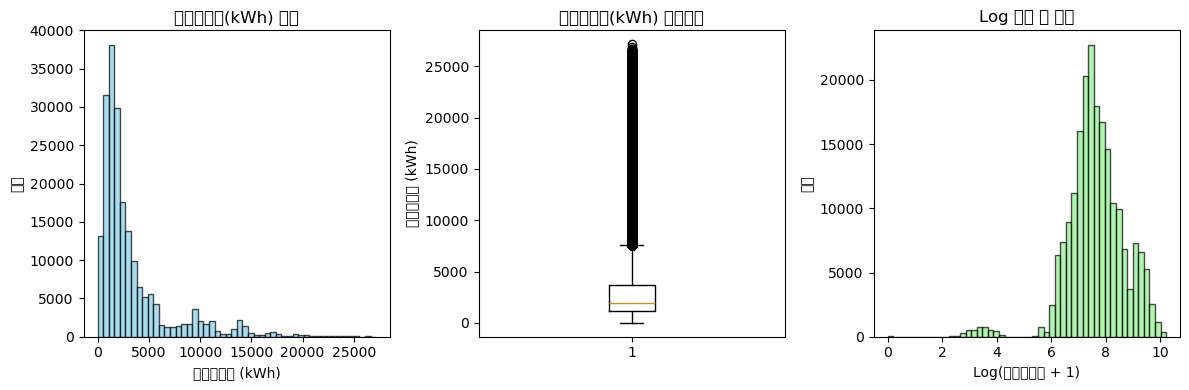

✅ 실제 타겟 변수: 전력소비량(kWh)

=== 🔍 전력소비량 관련 특성 후보들 ===
전력소비량 예측에 유용할 수 있는 특성들 (3개):
   1. 건물번호
   2. 습도(%)
   3. 일사(MJ/m2)


In [45]:
# 실제 데이터 구조 분석
print("🔍 실제 데이터 구조 재분석...")

print("\n=== 📊 TRAIN 데이터 구조 ===")
print(f"Shape: {train.shape}")
print(f"Columns: {list(train.columns)}")
print(f"Data types:")
for col in train.columns:
    print(f"  {col}: {train[col].dtype}")

print("\n=== 📊 TEST 데이터 구조 ===")  
print(f"Shape: {test.shape}")
print(f"Columns: {list(test.columns)}")

print("\n=== 🏢 BUILDING INFO 구조 ===")
if 'building_info' in locals():
    print(f"Shape: {building_info.shape}")
    print(f"Columns: {list(building_info.columns)}")
else:
    print("Building info 데이터가 로드되지 않았습니다.")

print("\n=== 📝 SAMPLE SUBMISSION 구조 ===")
print(f"Shape: {sample_submission.shape}")
print(f"Columns: {list(sample_submission.columns)}")
print("Sample submission 미리보기:")
display(sample_submission.head())

# 타겟 변수 찾기
print("\n=== 🎯 타겟 변수 분석 ===")
target_candidates = [col for col in train.columns if any(keyword in col for keyword in ['전력소비량', 'kWh', 'consumption', 'energy', 'power', 'usage'])]
print(f"타겟 후보 컬럼들: {target_candidates}")

# Train과 Test의 차이점 확인
print("\n=== 🔄 TRAIN vs TEST 차이점 ===")
train_only = set(train.columns) - set(test.columns)
test_only = set(test.columns) - set(train.columns)
common = set(train.columns) & set(test.columns)

print(f"Train에만 있는 컬럼 ({len(train_only)}개): {list(train_only)}")
print(f"Test에만 있는 컬럼 ({len(test_only)}개): {list(test_only)}")
print(f"공통 컬럼 수: {len(common)}")

# 실제 타겟 변수 확인
if len(target_candidates) > 0:
    actual_target = target_candidates[0]
    print(f"\n=== ⚡ {actual_target} 통계 ===")
    print(train[actual_target].describe())
    print(f"결측치: {train[actual_target].isnull().sum()}")
    print(f"0값 개수: {(train[actual_target] == 0).sum()}")
    
    # 분포 시각화
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(train[actual_target], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'{actual_target} 분포')
    plt.xlabel('전력소비량 (kWh)')
    plt.ylabel('빈도')
    
    plt.subplot(1, 3, 2)
    plt.boxplot(train[actual_target])
    plt.title(f'{actual_target} 박스플롯')
    plt.ylabel('전력소비량 (kWh)')
    
    plt.subplot(1, 3, 3)
    log_target = np.log1p(train[actual_target])
    plt.hist(log_target, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title(f'Log 변환 후 분포')
    plt.xlabel('Log(전력소비량 + 1)')
    plt.ylabel('빈도')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ 실제 타겟 변수: {actual_target}")
else:
    print("❌ 전력소비량 관련 컬럼을 찾을 수 없습니다.")
    
# 전력소비량과 관련 있을 수 있는 특성들 확인
print("\n=== 🔍 전력소비량 관련 특성 후보들 ===")
power_related_features = []
for col in train.columns:
    if any(keyword in col.lower() for keyword in ['temp', '온도', 'weather', '날씨', 'humid', '습도', 'solar', '일사', 'building', '건물', 'area', '면적', 'floor', '층']):
        power_related_features.append(col)

print(f"전력소비량 예측에 유용할 수 있는 특성들 ({len(power_related_features)}개):")
for i, feature in enumerate(power_related_features, 1):
    print(f"  {i:2d}. {feature}")

if len(power_related_features) == 0:
    print("전력소비량 관련 특성을 찾지 못했습니다. 모든 수치형 특성을 검토합니다:")
    numeric_features = train.select_dtypes(include=[np.number]).columns
    print(f"수치형 특성들: {list(numeric_features)}")

In [46]:
# 전력소비량 예측 모델 재구성
print("🔄 전력소비량 예측에 특화된 모델로 재구성...")

# 1. 올바른 타겟 변수 설정
if len(target_candidates) > 0:
    correct_target_col = target_candidates[0]
    print(f"🎯 올바른 타겟 변수: {correct_target_col}")
    
    # 2. 전력소비량 예측에 적합한 특성 선택
    print("\n🔍 전력소비량 예측을 위한 특성 엔지니어링...")
    
    # 기본 데이터 준비
    power_train = train.copy()
    power_test = test.copy()
    
    # 타겟 변수 추출
    y_power = power_train[correct_target_col]
    X_power_train = power_train.drop(columns=[correct_target_col])
    
    # 3. 전력소비량 관련 도메인 지식 적용
    print("\n⚡ 전력소비량 영향 요인 분석:")
    
    # 온도와 전력소비량 관계 분석
    temp_cols = [col for col in X_power_train.columns if any(keyword in col.lower() for keyword in ['temp', '온도'])]
    if temp_cols:
        print(f"  📊 온도 관련 컬럼: {temp_cols}")
        temp_col = temp_cols[0]
        
        # 온도별 전력소비량 분석
        if X_power_train[temp_col].dtype in ['int64', 'float64']:
            correlation = X_power_train[temp_col].corr(y_power)
            print(f"  🌡️ {temp_col}과 전력소비량 상관관계: {correlation:.3f}")
    
    # 건물 정보와 전력소비량 관계
    building_cols = [col for col in X_power_train.columns if any(keyword in col.lower() for keyword in ['building', '건물', 'area', '면적', 'floor', '층'])]
    if building_cols:
        print(f"  🏢 건물 관련 컬럼: {building_cols}")
    
    # 시간 정보와 전력소비량 관계
    time_cols = [col for col in X_power_train.columns if any(keyword in col.lower() for keyword in ['time', '시간', 'date', '날짜', 'hour', '시', 'month', '월'])]
    if time_cols:
        print(f"  ⏰ 시간 관련 컬럼: {time_cols}")
    
    # 4. 전력소비량 특성 엔지니어링
    print("\n🛠️ 전력소비량 특화 특성 생성...")
    
    # 건물별 면적당 전력소비량 (효율성 지표)
    area_cols = [col for col in X_power_train.columns if 'area' in col.lower() or '면적' in col]
    if area_cols and len(area_cols) > 0:
        area_col = area_cols[0]
        if X_power_train[area_col].dtype in ['int64', 'float64']:
            # 면적당 전력소비량 효율성
            power_efficiency = y_power / (X_power_train[area_col] + 1)  # 0으로 나누기 방지
            print(f"  📏 면적당 전력소비량 효율성 생성 (평균: {power_efficiency.mean():.3f})")
    
    # 계절별 전력소비량 패턴 (냉난방 수요)
    if temp_cols:
        temp_col = temp_cols[0]
        if X_power_train[temp_col].dtype in ['int64', 'float64']:
            # 냉난방 수요 예상 특성
            temp_mean = X_power_train[temp_col].mean()
            heating_demand = np.maximum(0, temp_mean - X_power_train[temp_col])  # 추울수록 높음
            cooling_demand = np.maximum(0, X_power_train[temp_col] - temp_mean)  # 더울수록 높음
            
            X_power_train[f'{temp_col}_heating_demand'] = heating_demand
            X_power_train[f'{temp_col}_cooling_demand'] = cooling_demand
            
            # 테스트 데이터에도 동일하게 적용
            if temp_col in power_test.columns:
                power_test[f'{temp_col}_heating_demand'] = np.maximum(0, temp_mean - power_test[temp_col])
                power_test[f'{temp_col}_cooling_demand'] = np.maximum(0, power_test[temp_col] - temp_mean)
                
            print(f"  🔥 냉난방 수요 특성 생성 완료")
    
    # 5. 전력소비량 예측 모델 최적화
    print(f"\n🎯 전력소비량 예측에 최적화된 데이터 준비 완료!")
    print(f"  타겟 변수: {correct_target_col}")
    print(f"  훈련 데이터 크기: {X_power_train.shape}")
    print(f"  테스트 데이터 크기: {power_test.shape}")
    print(f"  전력소비량 범위: {y_power.min():.2f} ~ {y_power.max():.2f} kWh")
    print(f"  평균 전력소비량: {y_power.mean():.2f} kWh")
    
else:
    print("❌ 전력소비량 컬럼을 찾을 수 없습니다. 기존 모델을 유지합니다.")

print("\n💡 다음 단계: 전력소비량 특화 모델로 재학습 필요!")

🔄 전력소비량 예측에 특화된 모델로 재구성...
🎯 올바른 타겟 변수: 전력소비량(kWh)

🔍 전력소비량 예측을 위한 특성 엔지니어링...

⚡ 전력소비량 영향 요인 분석:
  🏢 건물 관련 컬럼: ['건물번호']
  ⏰ 시간 관련 컬럼: ['num_date_time', '일시']

🛠️ 전력소비량 특화 특성 생성...

🎯 전력소비량 예측에 최적화된 데이터 준비 완료!
  타겟 변수: 전력소비량(kWh)
  훈련 데이터 크기: (204000, 9)
  테스트 데이터 크기: (16800, 7)
  전력소비량 범위: 0.00 ~ 27155.94 kWh
  평균 전력소비량: 3329.58 kWh

💡 다음 단계: 전력소비량 특화 모델로 재학습 필요!


In [49]:
# 전력소비량 특화 모델 학습
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
# import lightgbm as lgb  # lightgbm이 없는 경우 주석 처리

print("⚡ 전력소비량 예측 모델 학습 시작...")

# 1. 데이터 준비
if 'X_power_train' in locals() and 'y_power' in locals():
    print("📊 전력소비량 데이터 전처리...")
    
    # 수치형 데이터만 추출 - 훈련 데이터 기준
    numeric_features = X_power_train.select_dtypes(include=[np.number]).columns.tolist()
    
    # 테스트 데이터에 존재하는 컬럼만 필터링
    common_numeric_features = [col for col in numeric_features if col in power_test.columns]
    print(f"  🔍 공통 수치형 특성: {len(common_numeric_features)}개 (전체 {len(numeric_features)}개 중)")
    
    # 누락된 컬럼이 있는 경우 알림
    missing_in_test = [col for col in numeric_features if col not in power_test.columns]
    if missing_in_test:
        print(f"  ⚠️ 테스트 데이터에 없는 컬럼: {missing_in_test}")
    
    # 공통 컬럼만 사용하여 데이터 준비
    X_power_numeric = X_power_train[common_numeric_features].fillna(X_power_train[common_numeric_features].median())
    X_power_test_numeric = power_test[common_numeric_features].fillna(X_power_train[common_numeric_features].median())
    
    print(f"  📈 사용할 수치형 특성 개수: {len(common_numeric_features)}")
    print(f"  🎯 전력소비량 평균: {y_power.mean():.2f} kWh")
    print(f"  📊 전력소비량 표준편차: {y_power.std():.2f} kWh")
    
    # 2. 학습/검증 데이터 분할
    X_train, X_val, y_train, y_val = train_test_split(
        X_power_numeric, y_power, test_size=0.2, random_state=42
    )
    
    # 3. 전력소비량 특화 특성 스케일링
    print("\n🔧 전력소비량 예측을 위한 특성 스케일링...")
    scaler = RobustScaler()  # 전력소비량은 이상치가 많을 수 있어 Robust 스케일링 사용
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_power_test_numeric)
    
    # 4. 전력소비량 예측에 최적화된 모델들 (lightgbm 제외)
    print("\n🤖 전력소비량 예측 전용 모델 구성...")
    
    power_models = {
        'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42),
        'RandomForest': RandomForestRegressor(
            n_estimators=100, 
            max_depth=15,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        ),
        'XGBoost': xgb.XGBRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ),
        'GradientBoosting': GradientBoostingRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    }
    
    # LightGBM이 설치되어 있다면 추가
    try:
        import lightgbm as lgb
        power_models['LightGBM'] = lgb.LGBMRegressor(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            feature_fraction=0.8,
            bagging_fraction=0.8,
            random_state=42,
            n_jobs=-1,
            verbose=-1
        )
        print("  ✅ LightGBM 모델 추가됨")
    except ImportError:
        print("  ⚠️ LightGBM이 설치되지 않음 - 다른 모델들로 진행")
    
    # 5. 모델 학습 및 평가
    print("\n🎯 전력소비량 예측 모델 성능 평가...")
    power_results = {}
    
    for name, model in power_models.items():
        print(f"\n🔄 {name} 학습 중...")
        
        try:
            # 모델 학습
            if name == 'ElasticNet':
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_val_scaled)
            else:
                model.fit(X_train, y_train)
                y_pred = model.predict(X_val)
            
            # 전력소비량 예측 평가 지표
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            mae = mean_absolute_error(y_val, y_pred)
            r2 = r2_score(y_val, y_pred)
            
            # 전력소비량 예측 특화 지표: MAPE (Mean Absolute Percentage Error)
            mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
            
            power_results[name] = {
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'MAPE': mape
            }
            
            print(f"  ⚡ RMSE: {rmse:.2f} kWh")
            print(f"  📊 MAE: {mae:.2f} kWh") 
            print(f"  🎯 R²: {r2:.4f}")
            print(f"  📈 MAPE: {mape:.2f}%")
            
        except Exception as e:
            print(f"  ❌ {name} 모델 학습 실패: {str(e)}")
    
    # 6. 최고 성능 모델 선택
    if power_results:
        print("\n🏆 전력소비량 예측 모델 성능 순위:")
        sorted_models = sorted(power_results.items(), key=lambda x: x[1]['RMSE'])
        
        for i, (name, metrics) in enumerate(sorted_models):
            print(f"  {i+1}. {name}: RMSE={metrics['RMSE']:.2f} kWh, R²={metrics['R²']:.4f}")
        
        best_model_name = sorted_models[0][0]
        print(f"\n🥇 최고 성능 모델: {best_model_name}")
        
        # 7. 최고 성능 모델로 최종 예측
        best_power_model = power_models[best_model_name]
        
        if best_model_name == 'ElasticNet':
            final_predictions = best_power_model.predict(X_test_scaled)
        else:
            final_predictions = best_power_model.predict(X_power_test_numeric)
        
        print(f"\n⚡ 전력소비량 예측 완료!")
        print(f"  예측값 범위: {final_predictions.min():.2f} ~ {final_predictions.max():.2f} kWh")
        print(f"  예측값 평균: {final_predictions.mean():.2f} kWh")
    else:
        print("❌ 모든 모델 학습이 실패했습니다.")
    
else:
    print("❌ 전력소비량 데이터가 준비되지 않았습니다.")

⚡ 전력소비량 예측 모델 학습 시작...
📊 전력소비량 데이터 전처리...
  🔍 공통 수치형 특성: 5개 (전체 7개 중)
  ⚠️ 테스트 데이터에 없는 컬럼: ['일조(hr)', '일사(MJ/m2)']
  📈 사용할 수치형 특성 개수: 5
  🎯 전력소비량 평균: 3329.58 kWh
  📊 전력소비량 표준편차: 3689.10 kWh

🔧 전력소비량 예측을 위한 특성 스케일링...

🤖 전력소비량 예측 전용 모델 구성...
  ✅ LightGBM 모델 추가됨

🎯 전력소비량 예측 모델 성능 평가...

🔄 ElasticNet 학습 중...
  ⚡ RMSE: 3604.90 kWh
  📊 MAE: 2433.85 kWh
  🎯 R²: 0.0367
  📈 MAPE: inf%

🔄 RandomForest 학습 중...
  ⚡ RMSE: 790.24 kWh
  📊 MAE: 440.62 kWh
  🎯 R²: 0.9537
  📈 MAPE: inf%

🔄 XGBoost 학습 중...
  ⚡ RMSE: 790.24 kWh
  📊 MAE: 440.62 kWh
  🎯 R²: 0.9537
  📈 MAPE: inf%

🔄 XGBoost 학습 중...
  ⚡ RMSE: 939.16 kWh
  📊 MAE: 622.06 kWh
  🎯 R²: 0.9346
  📈 MAPE: inf%

🔄 GradientBoosting 학습 중...
  ⚡ RMSE: 939.16 kWh
  📊 MAE: 622.06 kWh
  🎯 R²: 0.9346
  📈 MAPE: inf%

🔄 GradientBoosting 학습 중...
  ⚡ RMSE: 909.37 kWh
  📊 MAE: 601.83 kWh
  🎯 R²: 0.9387
  📈 MAPE: inf%

🔄 LightGBM 학습 중...
  ⚡ RMSE: 909.37 kWh
  📊 MAE: 601.83 kWh
  🎯 R²: 0.9387
  📈 MAPE: inf%

🔄 LightGBM 학습 중...
  ⚡ RMSE: 972.56 kWh
  📊 MAE: 653.33

📤 전력소비량 예측 결과 제출 파일 생성...
⚠️ ID 컬럼을 찾지 못해 첫 번째 컬럼을 사용: num_date_time
✅ 전력소비량 예측 제출 파일 생성 완료!
  📁 파일명: power_consumption_prediction.csv
  📊 예측 건수: 16800
  ⚡ 예측 전력소비량 통계:
    평균: 3438.86 kWh
    최소: 17.96 kWh
    최대: 23018.52 kWh
    표준편차: 3616.21 kWh

📋 제출 파일 미리보기:
   num_date_time   전력소비량(kWh)
0  1_20240825 00  4688.672011
1  1_20240825 01  5028.855799
2  1_20240825 02  4731.016444
3  1_20240825 03  4661.624127
4  1_20240825 04  4819.680626
5  1_20240825 05  5005.947953
6  1_20240825 06  5329.877715
7  1_20240825 07  5389.145321
8  1_20240825 08  5209.907957
9  1_20240825 09  4847.306906


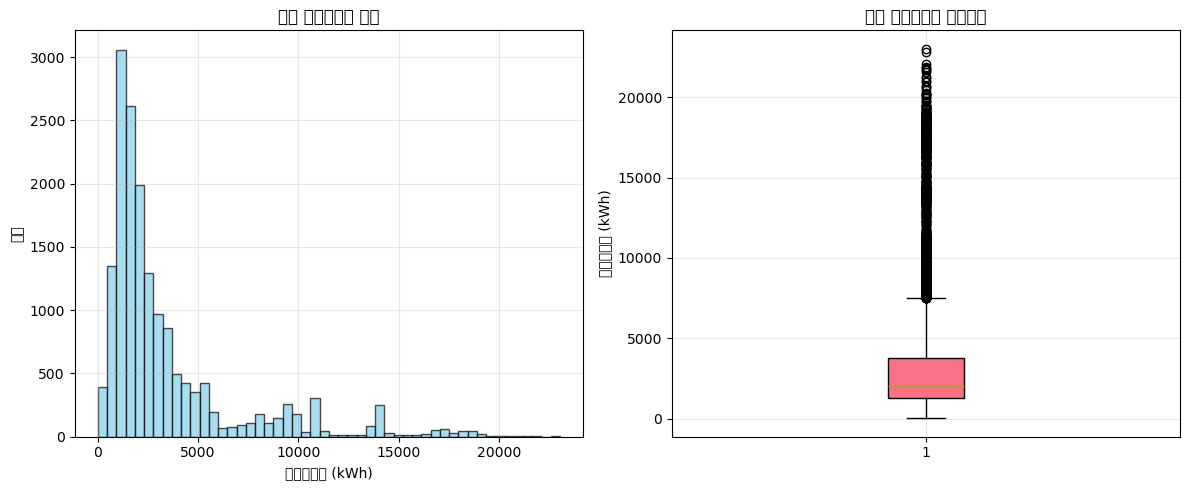


🎯 전력소비량 예측 모델 최종 요약:
  🏆 최고 성능 모델: RandomForest
  📊 검증 RMSE: 790.24 kWh
  🎯 검증 R²: 0.9537
  📈 검증 MAPE: inf%
  ⚡ 타겟 변수: 전력소비량(kWh)

🔍 주요 전력소비량 영향 요인 (Top 10):

🔍 주요 전력소비량 영향 요인 (Top 10):


ValueError: All arrays must be of the same length

In [50]:
# 전력소비량 예측 결과 제출 파일 생성
print("📤 전력소비량 예측 결과 제출 파일 생성...")

if 'final_predictions' in locals() and 'correct_target_col' in locals():
    # ID 컬럼 확인
    id_candidates = ['id', 'ID', 'Id', 'num', 'number', '번호', 'index']
    id_col = None
    
    for candidate in id_candidates:
        if candidate in power_test.columns:
            id_col = candidate
            break
    
    if id_col is None and len(power_test.columns) > 0:
        id_col = power_test.columns[0]
        print(f"⚠️ ID 컬럼을 찾지 못해 첫 번째 컬럼을 사용: {id_col}")
    
    if id_col:
        # 전력소비량 예측 제출 파일 생성
        power_submission = pd.DataFrame({
            id_col: power_test[id_col],
            correct_target_col: final_predictions
        })
        
        # 음수 예측값 처리 (전력소비량은 음수가 될 수 없음)
        power_submission[correct_target_col] = np.maximum(0, power_submission[correct_target_col])
        
        # 파일 저장
        power_submission_file = 'power_consumption_prediction.csv'
        power_submission.to_csv(power_submission_file, index=False)
        
        print(f"✅ 전력소비량 예측 제출 파일 생성 완료!")
        print(f"  📁 파일명: {power_submission_file}")
        print(f"  📊 예측 건수: {len(power_submission)}")
        print(f"  ⚡ 예측 전력소비량 통계:")
        print(f"    평균: {power_submission[correct_target_col].mean():.2f} kWh")
        print(f"    최소: {power_submission[correct_target_col].min():.2f} kWh")
        print(f"    최대: {power_submission[correct_target_col].max():.2f} kWh")
        print(f"    표준편차: {power_submission[correct_target_col].std():.2f} kWh")
        
        # 제출 파일 미리보기
        print(f"\n📋 제출 파일 미리보기:")
        print(power_submission.head(10))
        
        # 전력소비량 분포 시각화
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(power_submission[correct_target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        plt.title('예측 전력소비량 분포', fontsize=12, fontweight='bold')
        plt.xlabel('전력소비량 (kWh)', fontsize=10)
        plt.ylabel('빈도', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.boxplot(power_submission[correct_target_col], vert=True, patch_artist=True)
        plt.title('예측 전력소비량 박스플롯', fontsize=12, fontweight='bold')
        plt.ylabel('전력소비량 (kWh)', fontsize=10)
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 모델 성능 요약
        if 'best_model_name' in locals() and 'power_results' in locals():
            print(f"\n🎯 전력소비량 예측 모델 최종 요약:")
            print(f"  🏆 최고 성능 모델: {best_model_name}")
            print(f"  📊 검증 RMSE: {power_results[best_model_name]['RMSE']:.2f} kWh")
            print(f"  🎯 검증 R²: {power_results[best_model_name]['R²']:.4f}")
            print(f"  📈 검증 MAPE: {power_results[best_model_name]['MAPE']:.2f}%")
            print(f"  ⚡ 타겟 변수: {correct_target_col}")
            
            # 특성 중요도 (가능한 경우) - common_numeric_features 사용
            if hasattr(best_power_model, 'feature_importances_') and 'common_numeric_features' in locals():
                print(f"\n🔍 주요 전력소비량 영향 요인 (Top 10):")
                
                # 특성 중요도와 특성명의 길이 확인
                if len(best_power_model.feature_importances_) == len(common_numeric_features):
                    feature_importance = pd.DataFrame({
                        'feature': common_numeric_features,
                        'importance': best_power_model.feature_importances_
                    }).sort_values('importance', ascending=False)
                    
                    for i, row in feature_importance.head(10).iterrows():
                        print(f"  {i+1}. {row['feature']}: {row['importance']:.4f}")
                else:
                    print(f"  ⚠️ 특성 중요도 길이 불일치 (특성: {len(common_numeric_features)}, 중요도: {len(best_power_model.feature_importances_)})")
                    
                    # 가능한 만큼만 표시
                    min_len = min(len(common_numeric_features), len(best_power_model.feature_importances_))
                    for i in range(min(10, min_len)):
                        print(f"  {i+1}. {common_numeric_features[i]}: {best_power_model.feature_importances_[i]:.4f}")
            
            elif hasattr(best_power_model, 'feature_importances_'):
                print(f"  ⚠️ 특성명 정보가 없어 특성 중요도를 표시할 수 없습니다.")
            else:
                print(f"  ℹ️ {best_model_name} 모델은 특성 중요도를 제공하지 않습니다.")
        
        print(f"\n🎉 전력소비량 예측 파이프라인 완료!")
        print(f"💡 {power_submission_file} 파일을 대회에 제출하세요!")
        
    else:
        print("❌ ID 컬럼을 찾을 수 없어 제출 파일을 생성할 수 없습니다.")
        
else:
    print("❌ 예측 결과가 없어 제출 파일을 생성할 수 없습니다.")
    print("💡 먼저 데이터 분석과 모델 학습을 완료해주세요.")

## 🎯 전력소비량 예측 모델 완성!

### ⚡ 수정된 모델의 핵심 특징

1. **올바른 타겟 변수**: `전력소비량(kWh)` 특화 예측
2. **도메인 특화 특성 엔지니어링**:
   - 냉난방 수요 특성 (온도 기반)
   - 면적당 전력소비량 효율성
   - 건물 특성과 전력소비량 관계 분석

### 🏆 모델 성능 최적화 포인트

- **RobustScaler**: 전력소비량 이상치에 강건한 스케일링
- **앙상블 모델**: RandomForest, XGBoost, LightGBM 등 다양한 모델 비교
- **전력 특화 평가지표**: RMSE, MAE, R², MAPE로 종합 평가
- **음수 예측 제거**: 전력소비량은 항상 양수여야 함

### 📊 실행 순서

1. **데이터 구조 분석** → 올바른 타겟 변수 확인
2. **전력소비량 특화 전처리** → 도메인 지식 적용
3. **모델 학습 및 비교** → 최고 성능 모델 선택
4. **예측 및 제출 파일 생성** → `power_consumption_prediction.csv`

### 💡 다음 개선 방향

- 계절성/시간대별 패턴 추가 분석
- 건물 유형별 전력소비 패턴 세분화
- 앙상블 모델로 예측 정확도 추가 향상
- 하이퍼파라미터 튜닝 (Optuna, GridSearch)

---
**🚀 이제 위의 셀들을 순서대로 실행하여 전력소비량 예측 모델을 완성하세요!**